In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

# understat import for understat api
import asyncio
import json
import aiohttp
from understat import Understat
year = ['2014','2015','2016','2017','2018','2019','2020']

import sys,importlib
# importlib.reload(sys.modules['function'])
from function import *

modèle regression logistique 
* résultat :
    * européen
    * non-européen

* Critère défense : 
    * valeur
    * taille
    * vitesse
    * expérience
    * (poid)

# Projet 8 - Arsenal, européen ?

Préparation des données

In [2]:
ligue_df_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_table("EPL", i)
            ligue_df = pd.DataFrame(data=table)
            ligue_df['year'] = i
            ligue_df['Rank'] = ligue_df.index
            ligue_df_all.append(ligue_df)
        df = pd.concat(ligue_df_all)
        return df
loop = asyncio.get_event_loop()
import nest_asyncio
nest_asyncio.apply()
df_ligue = loop.run_until_complete(main())
df_ligue.columns = df_ligue.iloc[0]
df_ligue = df_ligue[1:] 
df_ligue.rename(columns={'2014':'Years',0:'Rank'},inplace=True)
df_ligue = df_ligue[['Rank','Team','M','W','D','L','G','GA','PTS','xG','xGA','xPTS','Years']]

In [3]:
df_ligue['Team'].unique()

array(['Chelsea', 'Manchester City', 'Arsenal', 'Manchester United',
       'Tottenham', 'Liverpool', 'Southampton', 'Swansea', 'Stoke',
       'Crystal Palace', 'Everton', 'West Ham', 'West Bromwich Albion',
       'Leicester', 'Newcastle United', 'Sunderland', 'Aston Villa',
       'Hull', 'Burnley', 'Queens Park Rangers', 'Team', 'Watford',
       'Bournemouth', 'Norwich', 'Middlesbrough', 'Brighton',
       'Huddersfield', 'Wolverhampton Wanderers', 'Cardiff', 'Fulham',
       'Sheffield United', 'Leeds'], dtype=object)

In [13]:
euro_crew = ['fc-chelsea', 'manchester-city', 'fc-arsenal', 'manchester-united','tottenham-hotspur', 'fc-liverpool', 'fc-southampton', 'swansea-city','stoke-city','crystal-palace',
             'fc-everton','west-ham-united','west-bromwich-albion','leicester-city','newcastle-united','afc-sunderland','aston-villa','hull-city','fc-burnley','queens-park-rangers',
             'fc-watford','afc-bournemouth','norwich-city','fc-middlesbrough','brighton-amp-hove-albion','huddersfield-town','wolverhampton-wanderers','cardiff-city','fc-fulham','sheffield-united','leeds-united']
num = ['631','281','11','985','148','31','379','2288','512','873','29','379','984','1003','762','289','405','3008','1132','1039','1010','989','1123','641','1237','1110','543','603','931','350','399']
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

In [14]:
for eq,num_eq in zip(euro_crew,num):
    print(eq,num_eq)

fc-chelsea 631
manchester-city 281
fc-arsenal 11
manchester-united 985
tottenham-hotspur 148
fc-liverpool 31
fc-southampton 379
swansea-city 2288
stoke-city 512
crystal-palace 873
fc-everton 29
west-ham-united 379
west-bromwich-albion 984
leicester-city 1003
newcastle-united 762
afc-sunderland 289
aston-villa 405
hull-city 3008
fc-burnley 1132
queens-park-rangers 1039
fc-watford 1010
afc-bournemouth 989
norwich-city 1123
fc-middlesbrough 641
brighton-amp-hove-albion 1237
huddersfield-town 1110
wolverhampton-wanderers 543
cardiff-city 603
fc-fulham 931
sheffield-united 350
leeds-united 399


In [16]:
header_crew = ['Position', 'Valeur maximum']
df_crew = []

for eq,num_eq in zip(euro_crew,num):
    for k in year:
        try:
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            
        except TimeoutError:
            print('k')
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            continue
df_value_max = pd.concat(df_crew)

fc-chelsea 2014


<ipython-input-16-533fd743d504>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Position'] = 'Total'


fc-chelsea 2015
fc-chelsea 2016
fc-chelsea 2017
fc-chelsea 2018
fc-chelsea 2019
fc-chelsea 2020
manchester-city 2014
manchester-city 2015
manchester-city 2016
manchester-city 2017
manchester-city 2018
manchester-city 2019
manchester-city 2020
fc-arsenal 2014
fc-arsenal 2015
fc-arsenal 2016
fc-arsenal 2017
fc-arsenal 2018
fc-arsenal 2019
fc-arsenal 2020
manchester-united 2014
manchester-united 2015
manchester-united 2016
manchester-united 2017
manchester-united 2018
manchester-united 2019
manchester-united 2020
tottenham-hotspur 2014
tottenham-hotspur 2015
tottenham-hotspur 2016
tottenham-hotspur 2017
tottenham-hotspur 2018
tottenham-hotspur 2019
tottenham-hotspur 2020
fc-liverpool 2014
fc-liverpool 2015
fc-liverpool 2016
fc-liverpool 2017
fc-liverpool 2018
fc-liverpool 2019
fc-liverpool 2020
fc-southampton 2014
fc-southampton 2015
fc-southampton 2016
fc-southampton 2017
fc-southampton 2018
fc-southampton 2019
fc-southampton 2020
swansea-city 2014
swansea-city 2015
swansea-city 2016
swa

In [17]:
df_crew = []
header_crew = ['Positions', 'Âge', 'Valeur marchande', 'Valeur marchande moyenne']
for eq,num_eq in zip(euro_crew,num):
    print(eq)
    if eq == 'thonon-evian-grand-geneve-fc':
        for k in year[:3]:

            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            body = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tbody.find_all('td')
            foot = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tfoot.find_all('tr')
            x = 0
            table_list = [header_crew]
            body_list = []
            for g in body:

                body_list.append(g.text)
                x = x + 1
                if x == 5:
                    table_list.append(body_list[1:])
                    body_list = []
                    x = 0

            for h in foot: 
                foot_list = []
                for gk2 in h.find_all('td'):
                    foot_list.append(gk2.text)
                table_list.append(foot_list)

            value_crew = pd.DataFrame(data=table_list)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            #print(value_crew,k)
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            df_crew.append(value_crew)
    else:
        for k in year:

            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            body = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tbody.find_all('td')
            foot = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tfoot.find_all('tr')
            x = 0
            table_list = [header_crew]
            body_list = []
            for g in body:

                body_list.append(g.text)
                x = x + 1
                if x == 5:
                    table_list.append(body_list[1:])
                    body_list = []
                    x = 0

            for h in foot: 
                foot_list = []
                for gk2 in h.find_all('td'):
                    foot_list.append(gk2.text)
                table_list.append(foot_list)

            value_crew = pd.DataFrame(data=table_list)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            #print(value_crew,k)
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            df_crew.append(value_crew)
#print(df_crew)
df_euro_all = pd.concat(df_crew)

fc-chelsea
manchester-city
fc-arsenal
manchester-united
tottenham-hotspur
fc-liverpool
fc-southampton
swansea-city
stoke-city
crystal-palace
fc-everton
west-ham-united
west-bromwich-albion
leicester-city
newcastle-united
afc-sunderland
aston-villa
hull-city
fc-burnley
queens-park-rangers
fc-watford
afc-bournemouth
norwich-city
fc-middlesbrough
brighton-amp-hove-albion
huddersfield-town
wolverhampton-wanderers
cardiff-city
fc-fulham
sheffield-united
leeds-united


In [23]:
df_euro_all

,Positions,Âge,Valeur marchande,Valeur marchande moyenne,Years,Crew
1,Gardien,"26,60","42,75 mio. €","8,55 mio. €",2014,fc-chelsea
2,Défense,"24,18","129,75 mio. €","11,80 mio. €",2014,fc-chelsea
3,Milieu de terrain,"23,00","174,50 mio. €","19,39 mio. €",2014,fc-chelsea
4,Attaquant,"23,31","210,25 mio. €","16,17 mio. €",2014,fc-chelsea
5,Total:,"23,92","557,25 mio. €","14,66 mio. €",2014,fc-chelsea
...,...,...,...,...,...,...
1,Gardien,"23,67","21,00 mio. €","7,00 mio. €",2020,leeds-united
2,Défense,"24,00","70,25 mio. €","5,02 mio. €",2020,leeds-united
3,Milieu de terrain,"24,08","41,35 mio. €","3,45 mio. €",2020,leeds-united
4,Attaquant,"22,20","105,50 mio. €","10,55 mio. €",2020,leeds-united


In [24]:
df_euro_all.rename(columns={'Valeur marchande':'Valeur marchande (millions)','Valeur marchande moyenne':'Valeur marchande moyenne (millions)'},inplace=True)

In [27]:
# df_euro_all[['Position', 'Valeur maximum', 'Valeur marchande (millions)','Valeur marchande moyenne (millions)', 'Years', 'Crew']]

In [28]:
df_euro_all = df_euro_all[df_euro_all['Valeur marchande (millions)'] != '-']

In [29]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande moyenne (millions)']]

In [33]:
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        print(float(i.replace(' mrd. €','')))

1.17
1.01
1.2
1.05
1.04
1.17
1.0


In [38]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]

In [41]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande moyenne (millions)']]

In [46]:
list_vald = []
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande (millions)'] = list_vald

In [47]:
list_vald = []
for i in df_euro_all['Valeur marchande moyenne (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande moyenne (millions)'] = list_vald

In [48]:
df_euro_all['Positions'] = [i.replace(':','') for i in df_euro_all['Positions']]

In [49]:
df_euro_all['Crew'] = [i.replace('-',' ') for i in df_euro_all['Crew']]
df_euro_all['Crew'] = [i.replace('fc','') for i in df_euro_all['Crew']]

In [50]:
df_ligue = df_ligue[df_ligue['Team'] != 'Team']

In [64]:
df_ligue.to_csv('ligue_PL.csv',index=False)
df_value_max.to_csv('all_value_max_PL.csv',index=False)

In [52]:
df_euro_all.to_csv('all_value_euro_PL.csv',index=False)

In [53]:
ligue_player_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_players("EPL", i)
            ligue_player = pd.DataFrame(data=table)
            ligue_player['year'] = i
            ligue_player_all.append(ligue_player)
        df = pd.concat(ligue_player_all)
        return df
loop = asyncio.get_event_loop()

In [54]:
import nest_asyncio
nest_asyncio.apply()
df_ligue_player = loop.run_until_complete(main())

In [55]:
df_ligue_player.head()

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,year
0,619,Sergio Agüero,33,2551,26,25.270159743726254,8,5.568922242149711,148,33,4,0,F S,Manchester City,21,20.70318364351988,27.805154908448458,6.878173082135618,2014
1,647,Harry Kane,34,2589,21,17.15729223564267,4,3.922500966116786,112,27,4,0,F M S,Tottenham,19,14.873822528868914,16.488438992761075,5.549698735587299,2014
2,802,Diego Costa,26,2111,20,15.219103761017323,3,4.554670915938914,76,41,8,0,F S,Chelsea,19,14.45793492347002,21.365789908915758,5.2769727278500795,2014
3,848,Charlie Austin,35,3078,18,17.881850190460682,5,2.548747032880783,131,23,4,1,F,Queens Park Rangers,15,14.076042897999287,13.718276167288423,3.041321298107505,2014
4,498,Alexis Sánchez,35,2967,16,13.451749975793064,8,8.49417957291007,122,82,4,0,F M S,Arsenal,16,12.690581078641117,27.15757153555751,10.736752955242991,2014


In [56]:
# print(df_ligue_player.dtypes)
# df_ligue_player.columns

In [57]:
df_ligue_player['xG'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xG']]
df_ligue_player['xA'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xA']]


In [58]:
column = ['games', 'time', 'goals',  'assists', 
       'shots', 'key_passes', 'yellow_cards', 'red_cards','npg', 'year']
for i in column:
    df_ligue_player[i] = df_ligue_player[i].astype(int)

In [59]:
column = ['xG','xA','npxG', 'xGChain', 'xGBuildup']
for i in column:
    df_ligue_player[i] = [np.around(float(i),decimals=4) for i in df_ligue_player[i]]
    

In [60]:
# df_ligue_player[df_ligue_player['team_title'] == 'Montpellier']

In [61]:
df_ligue_player.to_csv('all_player_PL.csv',index=False)

# Analyse

In [5]:
df_player = pd.read_csv('all_player_PL.csv',sep=',')
df_euro = pd.read_csv('all_value_euro_PL.csv',sep=',')
value_max = pd.read_csv('all_value_max_PL.csv',sep=',')

In [6]:
ligue = pd.read_csv('ligue_PL.csv',sep=',')

In [7]:
# column_2019 = ligue.columns
# psg_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i])
#     else:
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i]*1.4074074074074074)

# psg_2019_df = pd.DataFrame(data=psg_2019)
# psg_2019_df = psg_2019_df.T

In [8]:
# euro_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i],ligue[ligue['Years'] == 2019].iloc[11:][i]]))
#     else:
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i]*1.3571428571428572,ligue[ligue['Years'] == 2019].iloc[11:][i]*1.3571428571428572]))
# euro_2019_df = pd.DataFrame(data=euro_2019)
# euro_2019_df = euro_2019_df.T

In [9]:
# euro_ligue_without = ligue[ligue['Years'] != 2019]
ligue_corr = ligue
# ligue_corr = ligue_corr.sort_index()

In [10]:
list_xG = []
for i,a in zip(list(ligue['xG']),list(ligue['G'])):
    #print(i,a)
    list_xG.append(np.around(int(a)/int(i),decimals=3))

list_xGA = []
for e,h in zip(list(ligue['xGA']),list(ligue['GA'])):
    list_xGA.append(np.around(int(h)/int(e),decimals=3))

list_xPTS = []
for e,h in zip(list(ligue['xPTS']),list(ligue['PTS'])):
    list_xPTS.append(np.around(int(h)/int(e),decimals=3))

ligue_corr['xG coef'] = list_xG
ligue_corr['xGA coef'] = list_xGA
ligue_corr['xPTS coef'] = list_xPTS

In [11]:
ligue_corr['M'] = [np.around(i,decimals=0) for i in ligue_corr['M']]
ligue_corr['W'] = [np.around(i,decimals=0) for i in ligue_corr['W']]
ligue_corr['D'] = [np.around(i,decimals=0) for i in ligue_corr['D']]
ligue_corr['L'] = [np.around(i,decimals=0) for i in ligue_corr['L']]
ligue_corr['G'] = [np.around(i,decimals=3) for i in ligue_corr['G']]
ligue_corr['GA'] = [np.around(i,decimals=3) for i in ligue_corr['GA']]
ligue_corr['PTS'] = [np.around(i,decimals=0) for i in ligue_corr['PTS']]
ligue_corr['xG'] = [np.around(i,decimals=3) for i in ligue_corr['xG']]
ligue_corr['xGA'] = [np.around(i,decimals=3) for i in ligue_corr['xGA']]
ligue_corr['xPTS'] = [np.around(i,decimals=3) for i in ligue_corr['xPTS']]
ligue_corr['xG coef'] = [np.around(i,decimals=3) for i in ligue_corr['xG coef']]
ligue_corr['xGA coef'] = [np.around(i,decimals=3) for i in ligue_corr['xGA coef']]

In [13]:
ligue_corr.to_csv('ligue_corrected_PL.csv',index=False)

In [14]:
ligue_corr = pd.read_csv('ligue_corrected_PL.csv',sep=',')

In [15]:
ligue_corr[ligue_corr['Years'] == 2014]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
0,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160
1,2,Manchester City,38,24,7,7,83,38,79,75.82,40.50,73.10,2014,1.107,0.950,1.082
2,3,Arsenal,38,22,9,7,71,36,75,69.80,35.72,75.17,2014,1.029,1.029,1.000
3,4,Manchester United,38,20,10,8,62,37,70,54.21,39.84,63.03,2014,1.148,0.949,1.111
4,5,Tottenham,38,19,7,12,58,53,64,52.39,57.04,48.94,2014,1.115,0.930,1.333
5,6,Liverpool,38,18,8,12,52,48,62,51.70,38.25,61.17,2014,1.020,1.263,1.016
6,7,Southampton,38,18,6,14,54,33,60,54.97,39.11,62.82,2014,1.000,0.846,0.968
7,8,Swansea,38,16,8,14,46,49,56,40.90,55.94,43.32,2014,1.150,0.891,1.302
8,9,Stoke,38,15,9,14,48,45,54,46.26,47.03,51.97,2014,1.043,0.957,1.059
9,10,Crystal Palace,38,13,9,16,47,51,48,44.76,45.48,50.56,2014,1.068,1.133,0.960


In [16]:
ars = ligue_corr[ligue_corr['Team'] == 'Arsenal']

In [17]:
column = ['M', 'W', 'D', 'L', 'G', 'GA', 'PTS','Years']
for i in column:
    ars[i] = ars[i].astype(int)
    ligue_corr[i] = ligue_corr[i].astype(int)

<ipython-input-17-d197d87a3f85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ars[i] = ars[i].astype(int)


In [18]:
ligue_corr['Team'].unique()

array(['Chelsea', 'Manchester City', 'Arsenal', 'Manchester United',
       'Tottenham', 'Liverpool', 'Southampton', 'Swansea', 'Stoke',
       'Crystal Palace', 'Everton', 'West Ham', 'West Bromwich Albion',
       'Leicester', 'Newcastle United', 'Sunderland', 'Aston Villa',
       'Hull', 'Burnley', 'Queens Park Rangers', 'Watford', 'Bournemouth',
       'Norwich', 'Middlesbrough', 'Brighton', 'Huddersfield',
       'Wolverhampton Wanderers', 'Cardiff', 'Fulham', 'Sheffield United',
       'Leeds'], dtype=object)

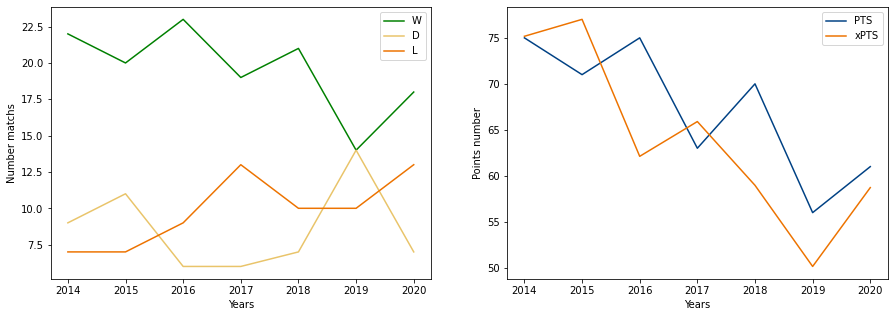

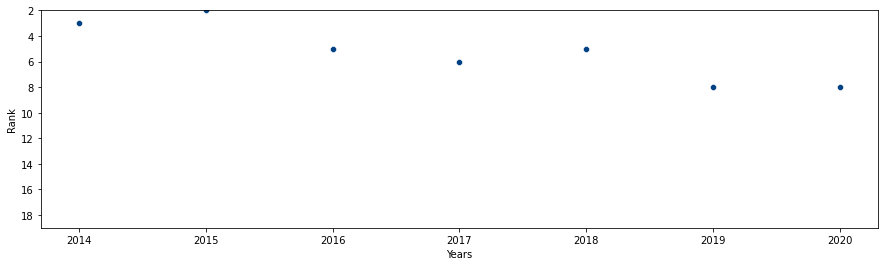

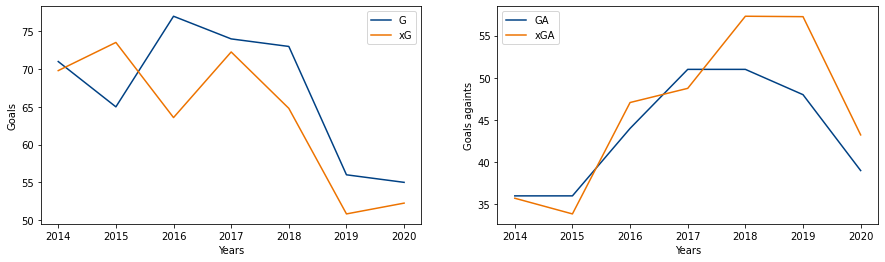

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[15,5])
# plt.plot(list(ars['Years']), list(ars['L']), label='L')
plt.subplot(121)
sns.lineplot(x="Years",y='W',data=ars,color='green',label='W')
sns.lineplot(x="Years",y='D',data=ars,color='#e9c46a',label='D')
sns.lineplot(x="Years",y='L',data=ars,color='#ED7300',label='L')
plt.ylabel('Number matchs')
plt.subplot(122)
sns.lineplot(x="Years",y='PTS',data=ars,color='#004184',label='PTS')
sns.lineplot(x="Years",y='xPTS',data=ars,color='#ED7300',label='xPTS')
plt.ylabel('Points number')
plt.show()
plt.figure(figsize=[15,4])
sns.scatterplot(x="Years",y='Rank',data=ars,color='#004184')
plt.ylim(19,2)
# for index,row in zip(range(0,len(ars.index)),ars['Rank']):
#     print(row)
#     plt.text(index*0.1,,str(row), color='black', ha="center")
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="Years",y='G',data=ars,color='#004184',label='G')
sns.lineplot(x="Years",y='xG',data=ars,color='#ED7300',label='xG')
plt.ylabel('Goals')
plt.subplot(122)
sns.lineplot(x="Years",y='GA',data=ars,color='#004184',label='GA')
sns.lineplot(x="Years",y='xGA',data=ars,color='#ED7300',label='xGA')
plt.ylabel('Goals againts')
plt.show()

### Player

In [20]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [21]:
euro_ligue_corr['Team'].unique()

array(['Chelsea', 'Manchester City', 'Arsenal', 'Manchester United',
       'Tottenham', 'Liverpool', 'Leicester', 'Southampton', 'West Ham'],
      dtype=object)

In [22]:
df_ars_players_stat = []
for i in year:
    goals = sum(df_player[(df_player['team_title'] == 'Arsenal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['goals'])    
    expect_goals = sum(df_player[(df_player['team_title'] == 'Arsenal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['xG'])
    np = sum(df_player[(df_player['team_title'] == 'Arsenal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npg'])    
    npG = sum(df_player[(df_player['team_title'] == 'Arsenal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npxG'])
    red_card = sum(df_player[(df_player['team_title'] == 'Arsenal')&(df_player['year'] == int(i))]['red_cards'])
    yellow_card = sum(df_player[(df_player['team_title'] == 'Arsenal')&(df_player['year'] == int(i))]['yellow_cards'])
    df_ars_players_stat.append(pd.DataFrame({'year':[i],'goals':[goals],'expect_goals':[expect_goals],'goals without penalty':[np],'expect goals without penalty':[npG],'red card':[red_card],'yellow card':[yellow_card]}))
stat_ars = pd.concat(df_ars_players_stat)

In [23]:
import numpy as np

In [24]:
list_goal_pourcent = []
for i,e in zip(stat_ars['goals'],ars['G']):
    #print(e,i)
    list_goal_pourcent.append(np.around(((i/e)*100),decimals=3))

In [25]:
stat_ars['Pourcent goal'] = list_goal_pourcent

A faire :

    - pourcentage de goals des 3 meilleurs buteurs sur l'ensemble des buts
    - red/yellow card 
 

In [26]:
stat_ars

,year,goals,expect_goals,goals without penalty,expect goals without penalty,red card,yellow card,Pourcent goal
0,2014,37,32.8887,31,27.5606,2,65,52.113
0,2015,35,35.5316,34,34.7704,4,40,53.846
0,2016,46,34.6250,44,31.5803,3,67,59.740
0,2017,31,29.8464,28,26.8017,2,53,41.892
0,2018,41,40.9273,37,37.1214,2,72,56.164
0,2019,37,30.0865,34,27.8031,5,86,66.071
0,2020,33,28.4792,27,23.9121,5,46,60.000


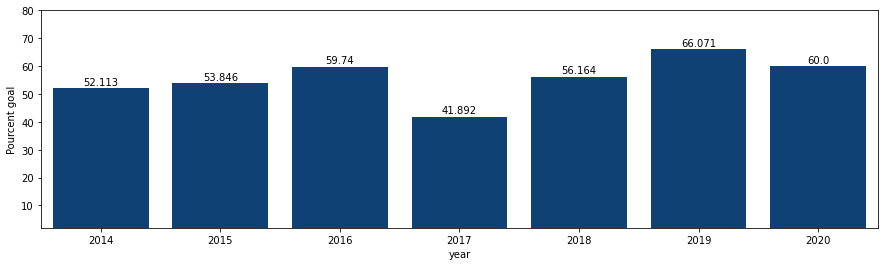

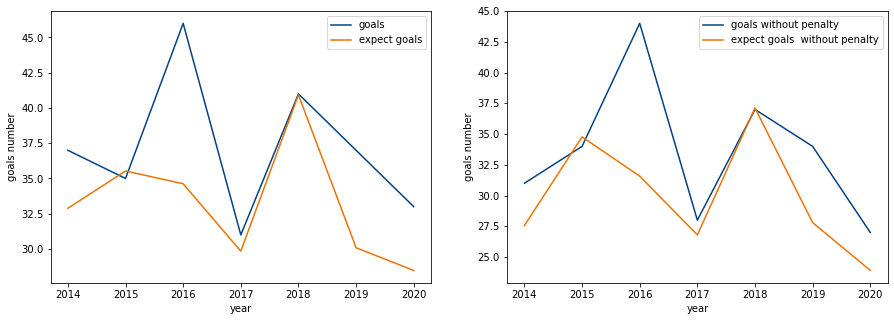

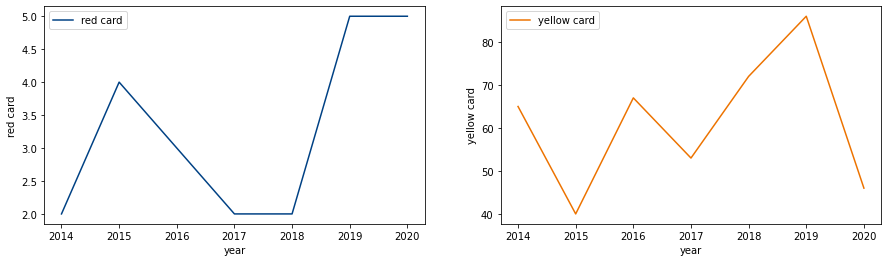

In [27]:
plt.figure(figsize=[15,4])
sns.barplot(x="year",y='Pourcent goal',data=stat_ars,color='#004184')
rects = stat_ars["year"]
labels = stat_ars['Pourcent goal']
for rect, label in zip(range(0,(len(rects))), labels):
    height = label
    plt.text(
        rect, height + 0.5, label, ha="center", va="bottom"
    )
plt.ylim(2,80)
plt.show()
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.lineplot(x="year",y='goals',data=stat_ars,color='#004184',label='goals')
sns.lineplot(x="year",y='expect_goals',data=stat_ars,color='#ED7300',label='expect goals')
plt.ylabel('goals number')
plt.subplot(122)
sns.lineplot(x="year",y='goals without penalty',data=stat_ars,color='#004184',label='goals without penalty')
sns.lineplot(x="year",y='expect goals without penalty',data=stat_ars,color='#ED7300',label='expect goals  without penalty')
plt.ylabel('goals number')
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="year",y='red card',data=stat_ars,color='#004184',label='red card')
plt.subplot(122)
sns.lineplot(x="year",y='yellow card',data=stat_ars,color='#ED7300',label='yellow card')
plt.show()

# Concurrents

In [28]:
ars

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
2,3,Arsenal,38,22,9,7,71,36,75,69.80,35.72,75.17,2014,1.029,1.029,1.000
21,2,Arsenal,38,20,11,7,65,36,71,73.53,33.86,77.01,2015,0.890,1.091,0.922
44,5,Arsenal,38,23,6,9,77,44,75,63.58,47.07,62.12,2016,1.222,0.936,1.210
65,6,Arsenal,38,19,6,13,74,51,63,72.27,48.75,65.90,2017,1.028,1.062,0.969
84,5,Arsenal,38,21,7,10,73,51,70,64.80,57.30,58.97,2018,1.141,0.895,1.207
107,8,Arsenal,38,14,14,10,56,48,56,50.82,57.25,50.15,2019,1.120,0.842,1.120
127,8,Arsenal,38,18,7,13,55,39,61,52.25,43.23,58.72,2020,1.058,0.907,1.052


In [29]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [30]:
# ligue_corr[ligue_corr['Years'] == 2019]

In [31]:
ars_point= ars.set_index('Years')[['PTS','Rank']].T

In [32]:
list(ars_point.values[0])

[75, 71, 75, 63, 70, 56, 61]

In [33]:
# euro_ligue_corr

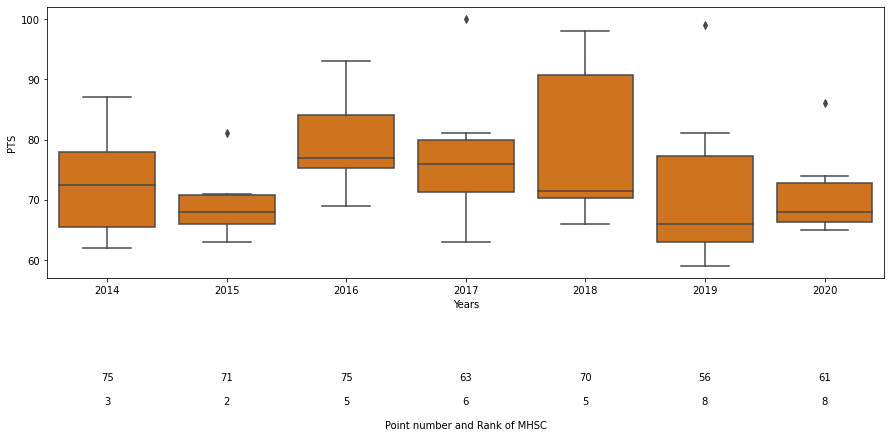

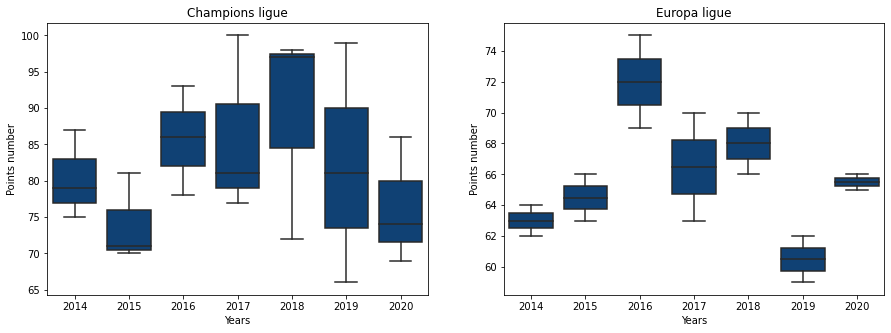

In [34]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='PTS',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_point.values[0])
labels_rank = list(ars_point.values[1])
plt.text(3,32,'Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 40, label1,horizontalalignment='center')
    plt.text(rect, 36, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Points number')
plt.title('Europa ligue')
plt.show()

# Expected points 

In [35]:
ars_expect_point = ars.set_index('Years')[['xPTS coef','Rank']].T

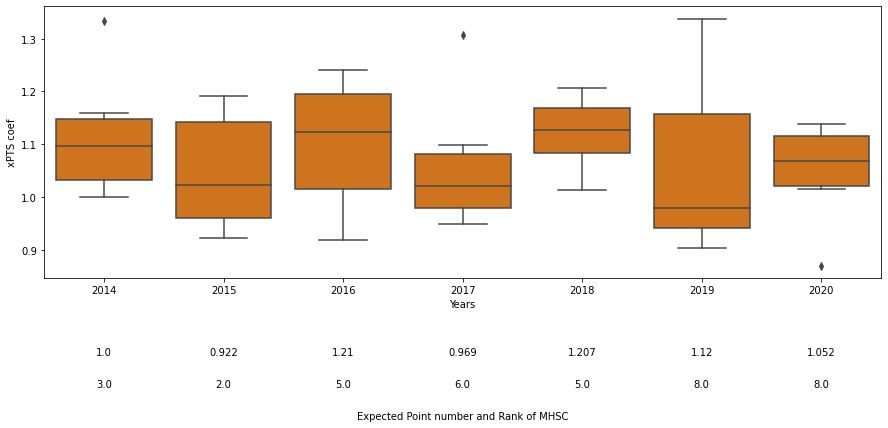

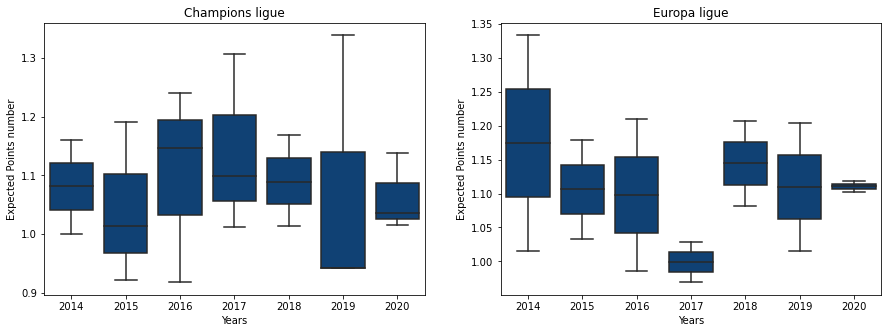

In [36]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='xPTS coef',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_expect_point.values[0])
labels_rank = list(ars_expect_point.values[1])
plt.text(3,0.58,'Expected Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 0.7, label1,horizontalalignment='center')
    plt.text(rect, 0.64, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Europa ligue')
plt.show()

# Valeurs marchandes

In [37]:
df_euro

,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions),Years,Crew
0,Gardien,"26,60",42.75,8.55,2014,chelsea
1,Défense,"24,18",129.75,11.80,2014,chelsea
2,Milieu de terrain,"23,00",174.50,19.39,2014,chelsea
3,Attaquant,"23,31",210.25,16.17,2014,chelsea
4,Total,"23,92",557.25,14.66,2014,chelsea
...,...,...,...,...,...,...
1080,Gardien,"23,67",21.00,7.00,2020,leeds united
1081,Défense,"24,00",70.25,5.02,2020,leeds united
1082,Milieu de terrain,"24,08",41.35,3.45,2020,leeds united
1083,Attaquant,"22,20",105.50,10.55,2020,leeds united


In [38]:
# for e,a,u in zip(df_euro['Valeur marchande (millions)'],df_euro['Crew'],df_euro['Positions']):
#     if 'K' in e:
#         print(e,a,u)

In [39]:
df_euro.dropna(axis=0,inplace=True)

In [40]:
# df_value_1 = []
# df_value_2 = []
# for i,e in zip(df_euro['Valeur marchande (millions)'],df_euro['Valeur marchande moyenne (millions)']):
#     if ('K' in e)&('K' in i):
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in e:
#         df_value_1.append(float(i.replace(',','.')))
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in i:
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.replace(',','.')))
#     else:
#         df_value_1.append(i.replace(',','.'))
#         df_value_2.append(i.replace(',','.'))

In [41]:
# df_euro['Valeur marchande (millions)'] = df_value_1
# df_euro['Valeur marchande moyenne (millions)'] = df_value_2

In [42]:
df_euro['Âge'] = [i.replace(',','.') for i in df_euro['Âge']] 
# df_euro['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande (millions)']] 

In [43]:
column = ['Âge', 'Valeur marchande (millions)',
       'Valeur marchande moyenne (millions)']
for i in column:
    df_euro[i] = df_euro[i].astype(float)

In [44]:
ars_max = value_max[value_max['Crew'] == 'fc-arsenal']

In [45]:
total = df_euro[(df_euro['Crew'] == 'fc-arsenal')&(df_euro['Positions'] == 'Total')]

In [46]:
# print(df_euro['Crew'].unique())
# print(euro_ligue_corr['Team'].unique())

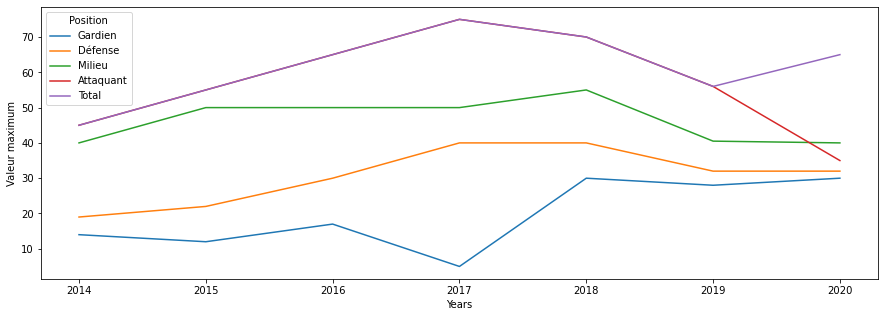

In [47]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur maximum',hue='Position',data=ars_max)
plt.show()

In [48]:
# ligue_corr['Team'].unique()

In [49]:
# list(df_euro['Team'].unique()[10:])

In [50]:
print(ligue_corr['Team'].unique())
print(df_euro['Crew'].unique())

['Chelsea' 'Manchester City' 'Arsenal' 'Manchester United' 'Tottenham'
 'Liverpool' 'Southampton' 'Swansea' 'Stoke' 'Crystal Palace' 'Everton'
 'West Ham' 'West Bromwich Albion' 'Leicester' 'Newcastle United'
 'Sunderland' 'Aston Villa' 'Hull' 'Burnley' 'Queens Park Rangers'
 'Watford' 'Bournemouth' 'Norwich' 'Middlesbrough' 'Brighton'
 'Huddersfield' 'Wolverhampton Wanderers' 'Cardiff' 'Fulham'
 'Sheffield United' 'Leeds']
[' chelsea' 'manchester city' ' arsenal' 'manchester united'
 'tottenham hotspur' ' liverpool' ' southampton' 'swansea city'
 'stoke city' 'crystal palace' ' everton' 'west ham united'
 'west bromwich albion' 'leicester city' 'newcastle united' 'a sunderland'
 'aston villa' 'hull city' ' burnley' 'queens park rangers' ' watford'
 'a bournemouth' 'norwich city' ' middlesbrough'
 'brighton amp hove albion' 'huddersfield town' 'wolverhampton wanderers'
 'cardiff city' ' fulham' 'sheffield united' 'leeds united']


In [51]:
# 'Chelsea' 'Manchester City'   

In [52]:
df_euro['Crew'] = [i.replace(' chelsea','Chelsea') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('manchester city','Manchester City') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' arsenal','Arsenal') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('manchester united','Manchester United') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('tottenham hotspur','Tottenham') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' liverpool','Liverpool') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' southampton','Southampton') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('swansea city','Swansea') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('stoke city','Stoke') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('crystal palace','Crystal Palace') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' everton','Everton') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('newcastle united','Newcastle United') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('west ham united','West Ham') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('aston villa','Aston Villa') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('leicester city','Leicester') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('hull city','Hull') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' burnley','Burnley') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('queens park rangers','Queens Park Rangers') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('west bromwich albion','West Bromwich Albion') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' watford','Watford') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('a bournemouth','Bournemouth') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('norwich city','Norwich') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' middlesbrough','Middlesbrough') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('brighton amp hove albion','Brighton') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('huddersfield town','Huddersfield') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('wolverhampton wanderers','Wolverhampton Wanderers') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('cardiff city','Cardiff') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace(' fulham','Fulham') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('sheffield united','Sheffield United') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('leeds united','Leeds') for i in df_euro['Crew']]


df_euro.rename(columns={'Crew':'Team'},inplace=True)

In [53]:
df_lig_val = ligue_corr.merge(df_euro,how='inner',on=['Team','Years'])

In [54]:
df_lig_val

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Gardien,26.60,42.75,8.55
1,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Défense,24.18,129.75,11.80
2,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Milieu de terrain,23.00,174.50,19.39
3,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Attaquant,23.31,210.25,16.17
4,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Total,23.92,557.25,14.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Gardien,25.40,13.80,2.76
681,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Défense,24.13,55.70,3.71
682,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Milieu de terrain,23.73,40.25,3.66
683,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Attaquant,22.78,40.10,4.46


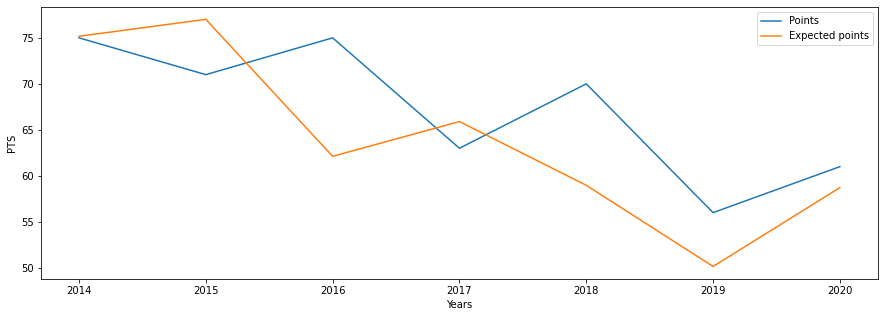

In [56]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
sns.lineplot(x='Years',y='PTS',data=ars,label='Points')
sns.lineplot(x='Years',y='xPTS',data=ars,label='Expected points')
# rects = year
# labels_rank = list(ars['Rank'])
# plt.text(3,0.32,'Point number and Rank of MHSC',horizontalalignment='center')
# for rect, label in zip(range(0,len(rects)), labels_rank):
#     plt.text(rect, 0.36, label,horizontalalignment='center')
plt.show()

### Corrélation valeurs marchande / résultats 

In [57]:
df_lig_val

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Gardien,26.60,42.75,8.55
1,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Défense,24.18,129.75,11.80
2,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Milieu de terrain,23.00,174.50,19.39
3,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Attaquant,23.31,210.25,16.17
4,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Total,23.92,557.25,14.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Gardien,25.40,13.80,2.76
681,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Défense,24.13,55.70,3.71
682,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Milieu de terrain,23.73,40.25,3.66
683,20,Sheffield United,38,7,2,29,20,63,23,33.16,66.11,29.92,2020,0.606,0.955,0.793,Attaquant,22.78,40.10,4.46


In [59]:
df_lig_val['win_rate'] = np.around(df_lig_val['W']/df_lig_val['M'],decimals=3)

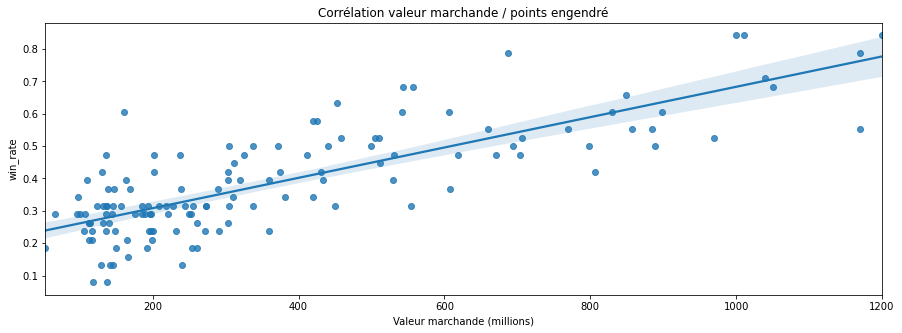

Covariance empirique :  35.300421916457985
Coefficient de Pearson :  0.7927753838077662

Les valeurs suivent une distribution linéaire


In [61]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='win_rate',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["win_rate"])
# plt.figure(figsize=[15,5])
# sns.regplot(x='Rank',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
# plt.show()
# corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']['Rank'],df_lig_val[df_lig_val['Positions'] == 'Total']['Valeur marchande (millions)'])


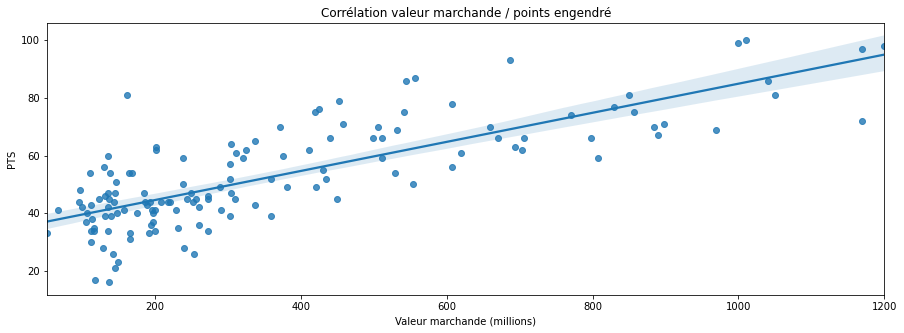

Covariance empirique :  3799.760708082477
Coefficient de Pearson :  0.7841925132374798

Les valeurs suivent une distribution linéaire


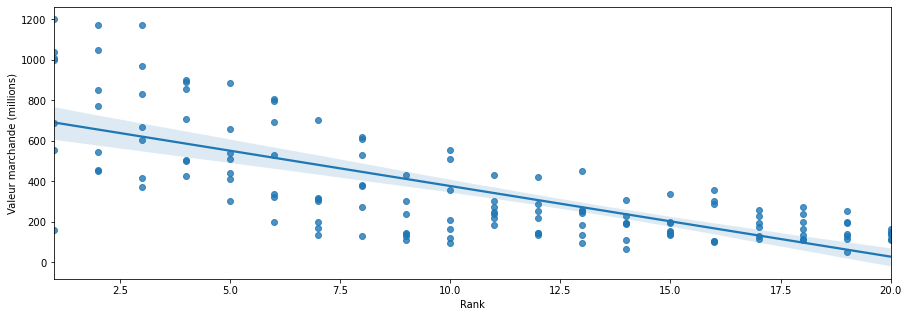

Covariance empirique :  -1142.5984202674622
Coefficient de Pearson :  -0.7272528840917395

Les valeurs suivent une distribution linéaire


In [58]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='PTS',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["PTS"])
plt.figure(figsize=[15,5])
sns.regplot(x='Rank',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']['Rank'],df_lig_val[df_lig_val['Positions'] == 'Total']['Valeur marchande (millions)'])


### Corrélation valeurs marchande / buts marqués - encaissés

In [143]:
df_lig_val[(df_lig_val['G'] > 50)&(df_lig_val['Positions'] == 'Attaquant')]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
3,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Attaquant,"23,31",210.25,16.17
8,2,Manchester City,38,24,7,7,83,38,79,75.82,40.50,73.10,2014,1.107,0.950,1.082,Attaquant,"23,86",125.50,17.93
13,3,Arsenal,38,22,9,7,71,36,75,69.80,35.72,75.17,2014,1.029,1.029,1.000,Attaquant,"22,45",137.00,12.45
18,4,Manchester United,38,20,10,8,62,37,70,54.21,39.84,63.03,2014,1.148,0.949,1.111,Attaquant,"24,27",241.80,21.98
23,5,Tottenham,38,19,7,12,58,53,64,52.39,57.04,48.94,2014,1.115,0.930,1.333,Attaquant,"24,38",85.30,10.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,6,West Ham,38,19,8,11,62,47,65,60.34,49.86,59.18,2020,1.033,0.959,1.102,Attaquant,"25,18",107.55,9.78
618,7,Tottenham,38,18,8,12,68,45,62,56.68,52.55,53.98,2020,1.214,0.865,1.170,Attaquant,"23,80",309.25,30.93
623,8,Arsenal,38,18,7,13,55,39,61,52.25,43.23,58.72,2020,1.058,0.907,1.052,Attaquant,"23,67",148.00,16.44
628,9,Leeds,38,18,5,15,62,54,59,59.26,63.02,51.81,2020,1.051,0.857,1.157,Attaquant,"22,20",105.50,10.55


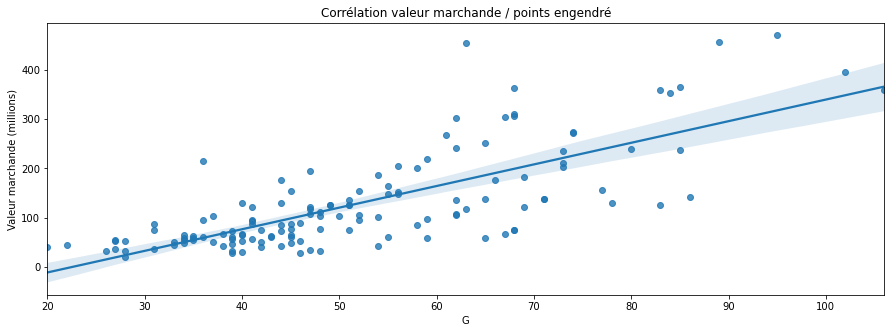

Covariance empirique :  1277.378090468325
Coefficient de Pearson :  0.7558771002758867

Les valeurs suivent une distribution linéaire


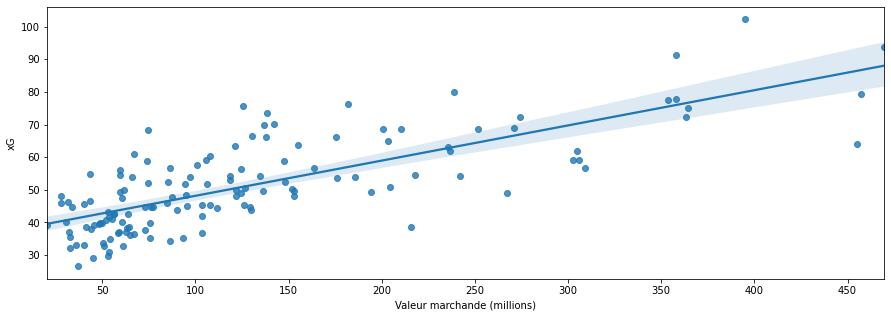

Covariance empirique :  1057.0443808194361
Coefficient de Pearson :  0.7591690037956615

Les valeurs suivent une distribution linéaire


In [144]:
# buts marqués
plt.figure(figsize=[15,5])
sns.regplot(x='G',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']["G"],df_lig_val[df_lig_val['Positions'] == 'Attaquant']["Valeur marchande (millions)"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xG',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']['Valeur marchande (millions)'],df_lig_val[df_lig_val['Positions'] == 'Attaquant']['xG'])


In [145]:
df_lig_val[df_lig_val['Positions'] == 'Gardien']

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Chelsea,38,26,9,3,73,32,87,68.64,31.52,75.32,2014,1.074,1.032,1.160,Gardien,"26,60",42.75,8.55
5,2,Manchester City,38,24,7,7,83,38,79,75.82,40.50,73.10,2014,1.107,0.950,1.082,Gardien,"31,67",21.25,7.08
10,3,Arsenal,38,22,9,7,71,36,75,69.80,35.72,75.17,2014,1.029,1.029,1.000,Gardien,"21,20",22.00,4.40
15,4,Manchester United,38,20,10,8,62,37,70,54.21,39.84,63.03,2014,1.148,0.949,1.111,Gardien,"26,00",32.50,6.50
20,5,Tottenham,38,19,7,12,58,53,64,52.39,57.04,48.94,2014,1.115,0.930,1.333,Gardien,"27,80",25.75,5.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,16,Brighton,38,9,14,15,40,46,41,53.82,39.91,61.41,2020,0.755,1.179,0.672,Gardien,"24,60",15.60,3.12
665,17,Burnley,38,10,9,19,33,55,39,38.13,59.06,38.10,2020,0.868,0.932,1.026,Gardien,"25,67",16.40,5.47
670,18,Fulham,38,5,13,20,27,53,28,41.06,57.64,42.42,2020,0.659,0.930,0.667,Gardien,"27,50",25.10,6.28
675,19,West Bromwich Albion,38,5,11,22,35,76,26,34.97,74.04,29.59,2020,1.029,1.027,0.897,Gardien,"28,80",9.75,1.95


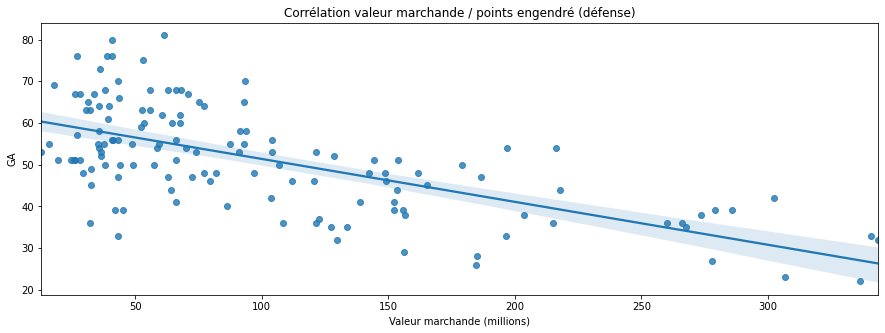

Covariance empirique :  -641.5720070328729
Coefficient de Pearson :  -0.6490513633207007

Les valeurs suivent une distribution linéaire


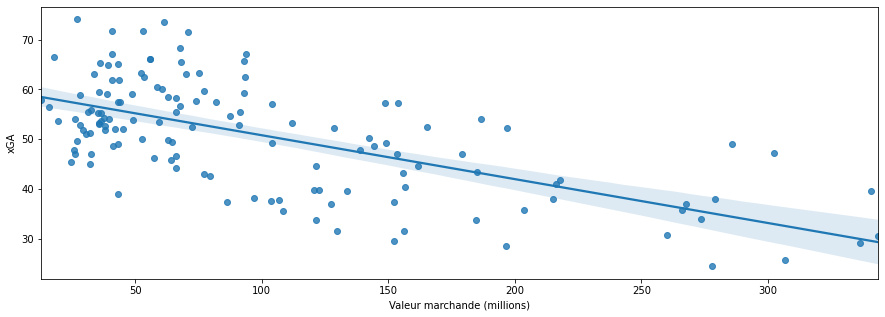

Covariance empirique :  -548.4013980233361
Coefficient de Pearson :  -0.6354344767632093

Les valeurs suivent une distribution linéaire


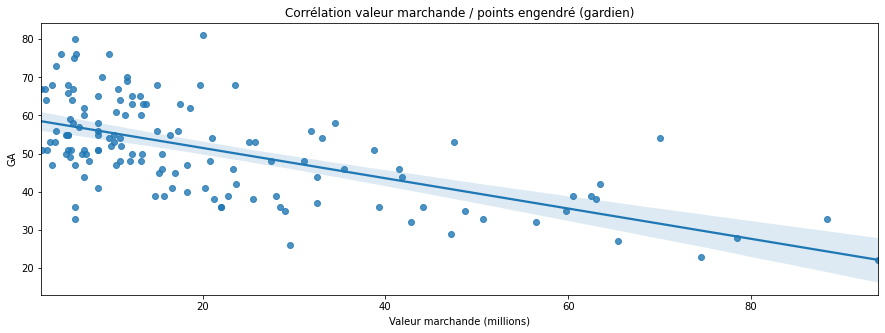

Covariance empirique :  -147.21929671266452
Coefficient de Pearson :  -0.6105151303859354

Les valeurs suivent une distribution linéaire


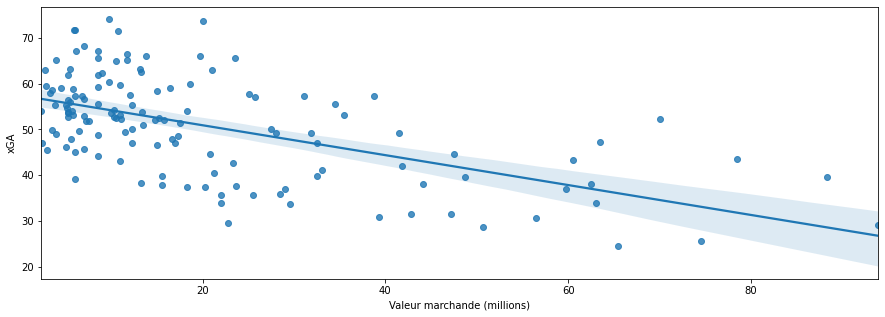

Covariance empirique :  -121.10066554957645
Coefficient de Pearson :  -0.5751972278435074

Les valeurs suivent une distribution linéaire


In [146]:
# buts encaissé
#défense
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.title('Corrélation valeur marchande / points engendré (défense)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Défense']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Défense']['Valeur marchande (millions)'])
#gardien
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.title('Corrélation valeur marchande / points engendré (gardien)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Gardien']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Gardien']['Valeur marchande (millions)'])


In [147]:
df_lig_val['Years'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [149]:
# df_lig_val[(df_lig_val['Team'] == 'Caen')]

In [75]:
df_value_pond_bef = []
for i in list(df_lig_val['Team'].unique()):
    for a in list(df_lig_val['Years'].unique()):
        try:
            gardien = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Gardien')]['Valeur marchande (millions)'])
            defense = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Défense')]['Valeur marchande (millions)'])
            milieu = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Milieu de terrain')]['Valeur marchande (millions)'])
            attaque = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Attaquant')]['Valeur marchande (millions)'])
            total = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Valeur marchande (millions)'])
            rank = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Rank']
            pts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['PTS']
            buts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['G']
            buts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['GA']
            xbuts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xG']
            xbuts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xGA']
            win_rate = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['win_rate']

            df_value_pond_bef.append(pd.DataFrame({'Rank':rank,'Team':i,'Years':a,'PTS':pts,'Win_rate':win_rate,'G':buts,'GA':buts_enc,'xG':xbuts,'xGA':xbuts_enc,'Value totale':total,'Value attaque': np.around((attaque+milieu*0.25)/1.25,decimals=3),'Value défense': np.around((gardien*0.5+defense*1.25+milieu*0.25)/2,decimals=3)}))
        except TypeError:
            continue

In [76]:
value_pond_bef = pd.concat(df_value_pond_bef)

In [80]:
value_pond_bef.to_csv('pond_value_PL.csv', index=False)

### Corrélation valeurs marchande pondérée / buts marqués - encaissés

In [25]:
value_pond = pd.read_csv('pond_value_PL.csv',sep=',')

In [82]:
value_pond[value_pond['Years'] == 2014]

,Rank,Team,Years,PTS,Win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense
0,1,Chelsea,2014,87,0.684,73,32,68.64,31.52,557,185.4,96.750
7,2,Manchester City,2014,79,0.632,83,38,75.82,40.50,452,114.9,109.438
14,3,Arsenal,2014,75,0.579,71,36,69.80,35.72,419,124.7,79.688
21,4,Manchester United,2014,70,0.526,62,37,54.21,39.84,505,203.6,87.000
28,5,Tottenham,2014,64,0.500,58,53,52.39,57.04,304,76.9,73.688
35,6,Liverpool,2014,62,0.474,52,48,51.70,38.25,324,95.6,69.000
42,7,Southampton,2014,60,0.474,54,33,54.97,39.11,135,38.7,30.312
49,8,Swansea,2014,56,0.421,46,49,40.90,55.94,130,45.6,23.125
53,9,Stoke,2014,54,0.395,48,45,46.26,47.03,110,27.7,23.938
57,10,Crystal Palace,2014,48,0.342,47,51,44.76,45.48,97,30.7,17.562


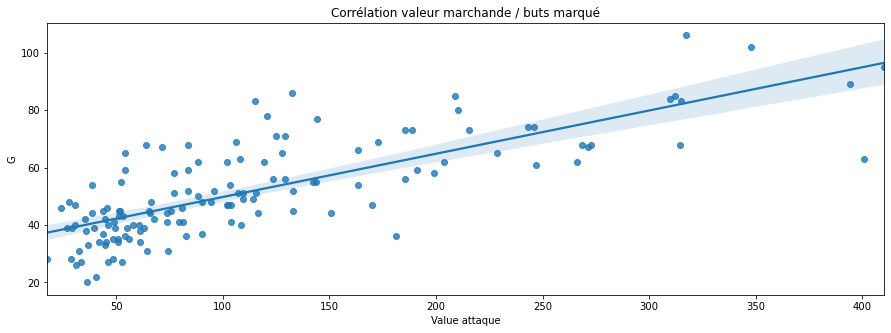

Covariance empirique :  1141.2818477276362
Coefficient de Pearson :  0.7677784105795946

Les valeurs suivent une distribution linéaire


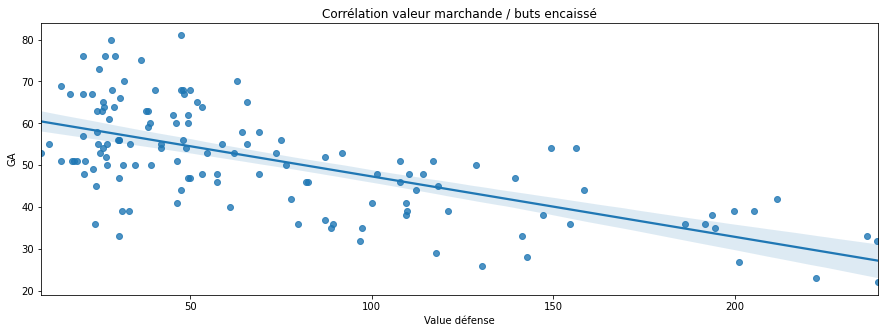

Covariance empirique :  -462.43197240129996
Coefficient de Pearson :  -0.6523450254494443

Les valeurs suivent une distribution linéaire


In [83]:
# buts marqué
#défense
plt.figure(figsize=[15,5])
sns.regplot(x="Value attaque",y='G',data=value_pond)
plt.title('Corrélation valeur marchande / buts marqué')
plt.show()
corré_quant(value_pond["Value attaque"],value_pond["G"])
plt.figure(figsize=[15,5])
sns.regplot(x='Value défense',y='GA',data=value_pond)
plt.title('Corrélation valeur marchande / buts encaissé')
plt.show()
corré_quant(value_pond['Value défense'],value_pond['GA'])

In [84]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = ['https://sofifa.com/players?type=all&lg%5B0%5D=13&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=140052&set=true&offset=',
        'https://sofifa.com/players?type=all&lg%5B0%5D=13&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=150059&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=13&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=160058&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=13&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=170099&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=13&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=180084&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=13&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=190075&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=13&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=200061&set=true&offset=']

In [85]:
b = 0
list_error_name = [' L. Messi',' L. Messi',' L. Messi',' Cristiano Ronaldo',' L. Messi',' L. Messi',' L. Messi']
list_page_glob = []
x = 2014
for i in page:
    y = 0
    list_page = []
    while str(requests.get("{}{}".format(str(i),str(y)), headers=headers)) == '<Response [200]>':
        print(x,y)
        #print("{}{}".format(str(i),str(y)),"{}{}".format(str(i),str(y))=='https://sofifa.com/players')
        pageTree = requests.get("{}{}".format(str(i),str(y)), headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        name = str(soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')[0].find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text)
        #print("{}{}".format(str(i),str(y)),name,b)
        if str(name) == list_error_name[b]:
            b = b + 1
            break
        else:
            list_name = []
            list_name.append(name)
            print(list_name)
            list_page.append("{}{}".format(str(i),str(y)))
            y = y +60
    x = x +1
    list_page_glob.append(list_page)

2014 0
[' L. Suárez']
2014 60


KeyboardInterrupt: 

In [162]:


df_fifa = []
x = 2014

for k in list_page_glob:
    #print(k)
    for e in k:
        pageTree = requests.get(e, headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        
        value = soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')
        #print(value)
        for i in value:
            
            name = i.find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text
            age = i.find('td',{'class':'col col-ae'}).text
            club = i.find_all('td',{'class':'col-name'})[1].find('div',{'class':'bp3-text-overflow-ellipsis'}).a.text
#             print(i)
            poste = i.find('td',{'class':'col col-bp'}).text
            poid = i.find('td',{'class':'col col-hi'}).text
            accele = int(i.find('td',{'class':'col col-sp'}).span.text)
            speed = int(i.find('td',{'class':'col col-ac'}).span.text)
            offensif = int(i.find('td',{'class':'col col-ta'}).span.text)
            tech = int(i.find('td',{'class':'col col-ts'}).span.text)
            mouv = int(i.find('td',{'class':'col col-to'}).span.text)
            def_gene = int(i.find('td',{'class':'col col-td'}).span.text)
            gardien = int(i.find('td',{'class':'col col-tg'}).span.text)
            df_fifa.append(pd.DataFrame({'name':[name],'poste':[poste],'Team':[club],'taille':[poid],'accélération':[accele],'speed':[speed],'offensif':[offensif],'technique':[tech],'mouvement':[mouv],'defense general':[def_gene],'gardien general':[gardien],'Years':x}))

        #print(df_fifa)
    x = x + 1
#     print(x)
fifa = pd.concat(df_fifa)

In [163]:
# for i in fifa[fifa['Years'] == 2020]['poid']:
#     print(i.split('"')[0])
#     dist = Distance(=i.split('"')[0].split("'")[0],inch=i.split('"')[0].split("'")[1])
#     print(dist.m)

In [164]:
fifa

,name,poste,Team,taille,accélération,speed,offensif,technique,mouvement,defense general,gardien general,Years
0,L. Suárez,BU,Liverpool,"5'11""",79,88,408,415,427,113,153,2014
0,R. van Persie,BU,Manchester United,"6'2""",75,74,422,414,376,76,39,2014
0,E. Hazard,MG,Chelsea,"5'8""",87,91,387,422,444,74,45,2014
0,S. Agüero,BU,Manchester City,"5'8""",85,93,401,397,440,70,59,2014
0,M. Özil,MOC,Arsenal,"5'11""",71,79,375,421,398,72,50,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
0,R. York,MOC,Sheffield United,"5'11""",55,66,226,220,299,145,50,2020
0,A. Parkes,G,Watford,"6'1""",18,32,50,79,186,39,254,2020
0,J. Cropper,DD,Burnley,"6'0""",68,69,205,216,298,146,48,2020
0,J. Davies,DLG,Brighton & Hove Albion,"5'6""",67,71,211,205,340,145,53,2020


In [165]:
fifa.to_csv('fifa_glob_PL.csv',index=False)

In [26]:
fifa = pd.read_csv('fifa_glob_PL.csv',sep=',')

In [27]:
list_taille = []
for i in fifa['taille']:
    list_taille.append(np.around(int(i.split('"')[0].split("'")[0])*30.48 + int(i.split('"')[0].split("'")[1])*2.54,decimals=0))

In [28]:
fifa['taille'] = list_taille

In [29]:
moy_playeurs = fifa.groupby(['poste','Years']).mean().reset_index()

In [30]:
moy_playeurs

,poste,Years,taille,accélération,speed,offensif,technique,mouvement,defense general,gardien general
0,AD,2014,177.886364,82.931818,84.136364,313.181818,332.204545,390.704545,100.500000,50.909091
1,AD,2015,175.550000,82.975000,84.450000,306.300000,326.925000,392.350000,101.650000,48.600000
2,AD,2016,176.500000,84.437500,85.656250,312.000000,330.968750,397.875000,101.062500,53.718750
3,AD,2017,174.833333,88.500000,89.333333,293.500000,320.500000,404.000000,88.333333,54.000000
4,AD,2018,175.142857,79.428571,81.857143,300.000000,304.571429,379.142857,89.857143,51.428571
...,...,...,...,...,...,...,...,...,...,...
100,MOC,2016,177.028986,70.144928,73.159420,314.260870,350.014493,360.405797,126.231884,51.840580
101,MOC,2017,178.431818,72.704545,74.318182,310.215909,342.556818,362.852273,126.761364,51.022727
102,MOC,2018,176.862500,70.662500,73.025000,307.950000,343.150000,361.512500,132.412500,51.975000
103,MOC,2019,177.500000,69.785714,72.557143,315.142857,352.885714,364.528571,143.785714,51.100000


In [31]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['BU','MOC', 'AG', 'AD','AT','MC']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['accélération'],value['speed'],value['offensif'],value['technique'],value['mouvement']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(k/int(value_moy['accélération']),decimals=3)
            speedo = np.around(a/int(value_moy['speed']),decimals=3)
            offense = np.around(j/int(value_moy['offensif']),decimals=3)
            tech = np.around(l/int(value_moy['technique']),decimals=3)
            mouv = np.around(g/int(value_moy['mouvement']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e],'accélération':[accel], 'speed':[speedo], 'offensif':[offense],
       'technique':[tech], 'mouvement':[mouv], 'Years':[i]}))
off_coef = pd.concat(df_off_coef)

In [32]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['DC', 'MDC', 'DLG','DG', 'DLD', 'DD']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['taille'],value['accélération'],value['speed'],value['defense general'],value['gardien general']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(a/int(value_moy['accélération']),decimals=3)
            speedo = np.around(j/int(value_moy['speed']),decimals=3)
            tail = np.around(k/float(value_moy['taille']),decimals=3)
            def_gene = np.around(l/int(value_moy['defense general']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e], 'taille':[tail],'accélération':[accel], 'speed':[speedo],
       'defense generale':[def_gene], 'Years':[i]}))
def_coef = pd.concat(df_off_coef)

In [33]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    value = fifa[(fifa['Years'] == i)&(fifa['poste'] == 'G')]
    for q,k,a in zip_longest(value['Team'],value['taille'],value['gardien general']):
        value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == 'G')]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
        tail = np.around(k/float(value_moy['taille']),decimals=3)
        gard = np.around(a/int(value_moy['gardien general']),decimals=3)
        df_off_coef.append(pd.DataFrame({'Team':[q],'poste':'G', 'taille':[tail],'gardien generale':[gard], 'Years':[i]}))
gard_coef = pd.concat(df_off_coef)

In [34]:
gard_coef['coef'] = np.around((gard_coef['taille']+gard_coef['gardien generale']*1.5)/2.5,decimals=5)

In [35]:
def_coef['coef'] = np.around((def_coef['taille']+def_coef['accélération']+def_coef['speed']+def_coef['defense generale']*1.5)/4.5,decimals=5)

In [36]:
off_coef['coef'] = np.around((off_coef['offensif']*1.5+off_coef['accélération']+off_coef['speed']+off_coef['mouvement']+off_coef['technique'])/5.5,decimals=5)

In [37]:
def_coef = def_coef[['Team','poste','Years','coef']]

In [38]:
gard_coef = gard_coef[['Team','poste','Years','coef']]

In [39]:
off_coef = off_coef[['Team','poste','Years','coef']]

In [40]:
list_def_coef = []
def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5
list_def_coef.append(def_coef[def_coef['poste'] == 'DC'])
list_def_coef.append(def_coef[def_coef['poste'] != 'DC'])
list_def_coef.append(gard_coef)
def_coef_glob = pd.concat(list_def_coef)

<ipython-input-40-03152599a842>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5


In [41]:
list_off_coef = []
off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75
list_off_coef.append(off_coef[off_coef['poste'] == 'MC'])
list_off_coef.append(off_coef[off_coef['poste'] != 'MC'])
off_coef_glob = pd.concat(list_off_coef)

<ipython-input-41-f028df8da51d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75


In [42]:
off_coef_glob = off_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [43]:
def_coef_glob = def_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [44]:
df_coef = def_coef_glob.merge(off_coef_glob,how='inner',on=['Team','Years'])
df_coef.rename(columns={'coef_x':'coef défense','coef_y':'coef attaque'},inplace=True)

In [45]:
df_coef['Team'].unique()

array(['Manchester United', 'Arsenal', 'Manchester City', 'Chelsea',
       'Liverpool', 'Tottenham Hotspur', 'Everton', 'Aston Villa',
       'Leicester City', 'Southampton', 'West Ham United', 'Sunderland',
       'Stoke City', 'Fulham', 'Newcastle United', 'Burnley',
       'Bournemouth', 'Crystal Palace', 'Cardiff City',
       'Sheffield United', 'Huddersfield Town', 'Norwich City',
       'Swansea City', 'Watford', 'Queens Park Rangers',
       'Wolverhampton Wanderers', 'Middlesbrough', 'West Bromwich Albion',
       'Brighton & Hove Albion', 'Hull City'], dtype=object)

In [47]:
df_coef['Team'] = [i.replace('Tottenham Hotspur','Tottenham') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Swansea City','Swansea') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Stoke City','Stoke') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace( 'West Ham United','West Ham') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Leicester City','Leicester') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Hull City','Hull') for i in df_coef['Team']]  
df_coef['Team'] = [i.replace('Norwich City','Norwich') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Brighton & Hove Albion','Brighton') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Huddersfield Town','Huddersfield') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Wolverhampton Wanderers','Wolverhampton Wanderers') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Cardiff City','Cardiff') for i in df_coef['Team']]

In [48]:
for i,h in zip(df_coef['Team'].unique(),value_pond['Team'].unique()):
#     print(i,h)
    if (i not in df_coef['Team'].unique())|(i not in value_pond['Team'].unique()):
        print(i,'i')
    elif (h not in value_pond['Team'].unique())|(h not in df_coef['Team'].unique()):
        print(h,'k')

Sunderland i
Leeds k


In [108]:
all_value = value_pond.merge(df_coef,how='inner',on=['Team','Years'])

In [109]:
all_value.to_csv('merge_value_PL.csv',index=False)

In [49]:
all_value = pd.read_csv('merge_value_PL.csv',sep=',')

In [50]:
list_euro = []
list_euro_detail = []
for i in all_value['Rank']:
    if i < 7:
        list_euro.append('Européen')
        if i < 5: 
            list_euro_detail.append('CL')
        else:
            list_euro_detail.append('EL')
    else:
        list_euro.append('Non-Européen')
        list_euro_detail.append('NE')
all_value['is_euro'] = list_euro
all_value['is_euro_detail'] = list_euro_detail

In [51]:
#méthode de calcul et d'affichage des cercles de corrélation et de l'ACP

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, pca, axis_ranks, labels=None, alpha=1):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    
    fig_1 = plt.figure(figsize=(8,7))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.savefig('Eboulis.png')
    plt.show(block=False)

In [52]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'Win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail'],
      dtype='object')

In [53]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from sklearn import preprocessing

data = all_value[['PTS', 'G', 'GA', 'Value totale',
       'Value attaque', 'Value défense', 'coef défense', 'coef attaque','Win_rate']]
X = data.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components = 4)
pca.fit(X_scaled)

PCA(n_components=4)

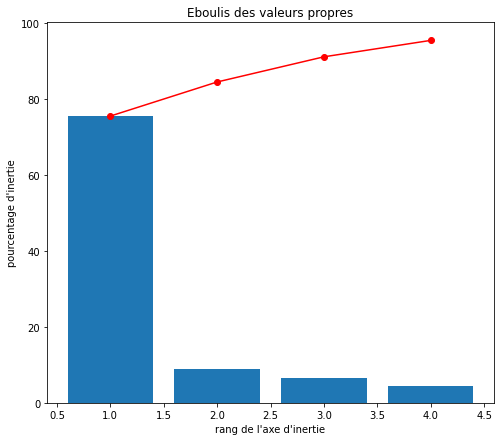

In [54]:
display_scree_plot(pca)

In [55]:
data.columns

Index(['PTS', 'G', 'GA', 'Value totale', 'Value attaque', 'Value défense',
       'coef défense', 'coef attaque', 'Win_rate'],
      dtype='object')

v1 : PTS
v2 : Buts marqués
v3 : Buts encaissés
v4 : Value totale
v5 : Value attaque
v6 : Value défense
v7 : coef défense
v8 : coef attaque
v9 : Win_rate


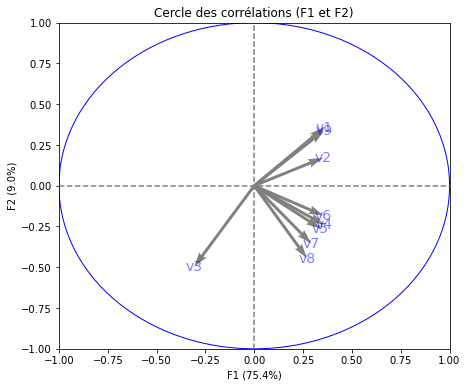

v3 est anti-corrélés aux variables PTS et coef attaque
v4,v5 et v6 ne sont corrélés à aucuns axes
v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information
     
F1 : Capacité à faire avoir de bonnes performances / bon classement
     
F2 : incapacité à défendre
     


In [56]:
#ACP
features = data.columns
pcs = pca.components_
var = ['v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11']

print('v1 : PTS')
print('v2 : Buts marqués')
print('v3 : Buts encaissés')
print('v4 : Value totale')
print('v5 : Value attaque')
print('v6 : Value défense')
print('v7 : coef défense')
print('v8 : coef attaque')
print('v9 : Win_rate')

#display_circles(pcs, 4, pca, [(0,1),(2,3),(4,5)],labels = np.array(features))
display_circles(pcs, 4, pca, [(0,1)],labels = np.array(var))

X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected_2, 4, pca2, [(0,1),(2,3)], alpha = 0.2)

print('v3 est anti-corrélés aux variables PTS et coef attaque')
print('v4,v5 et v6 ne sont corrélés à aucuns axes')
print("v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information")
print(' '*5)
print('F1 : Capacité à faire avoir de bonnes performances / bon classement')
print(' '*5)
print('F2 : incapacité à défendre')
print(' '*5)


plt.show()

In [57]:
f1 = []
f2 = []
for i in X_projected:
    f1.append(i[0])
    f2.append(i[1])
    
all_value['F1'] = f1
all_value['F2'] = f2

### La qualité de représentation des individus

In [58]:
data_compo = pd.DataFrame(X_projected,index=data.index,columns=["F"+str(i+1) for i in range(4)])
data_compo = data_compo.drop(['F3','F4'],axis=1)
data_compo

,F1,F2
0,2.988180,1.289834
1,0.762526,-1.574632
2,4.291422,1.079230
3,3.282176,-0.470508
4,4.574635,-1.591443
...,...,...
111,-1.844132,0.379362
112,-4.636708,-1.180343
113,-0.553755,1.237299
114,-1.195150,0.014745


In [59]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data_compo.values
#instanciation
sc = StandardScaler()
#transformation
Z = sc.fit_transform(X)

In [60]:
data_compo['is_euro'] = all_value['is_euro']
data_compo['is_euro_detail'] = all_value['is_euro_detail']

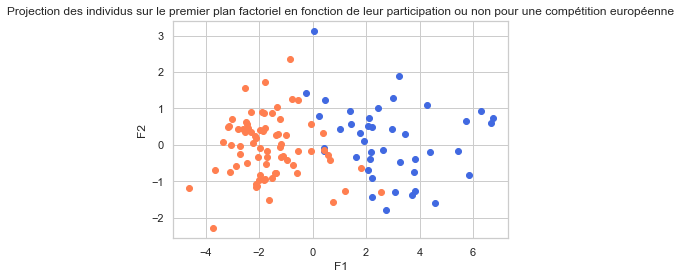

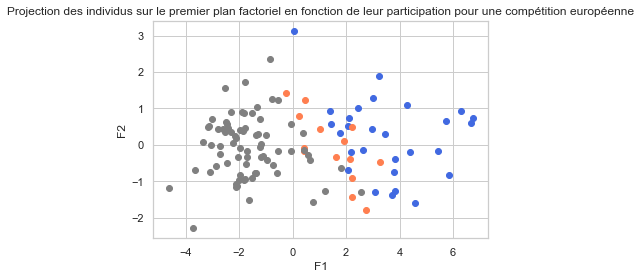

In [61]:
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro'] == 'Européen']['F1'],data_compo[data_compo['is_euro'] == 'Européen']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro'] == 'Non-Européen']['F1'],data_compo[data_compo['is_euro'] == 'Non-Européen']['F2'],c = 'coral')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation ou non pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'CL']['F1'],data_compo[data_compo['is_euro_detail'] == 'CL']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'EL']['F1'],data_compo[data_compo['is_euro_detail'] == 'EL']['F2'],c = 'coral')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'NE']['F1'],data_compo[data_compo['is_euro_detail'] == 'NE']['F2'],c = 'grey')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

In [62]:
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)

p = data_compo[['F1','F2']].shape[1]
di = np.sum(Z**2,axis=1)
contribu = pd.DataFrame({'d_i':di})
cos2 = coord**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di
data_cos = pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})

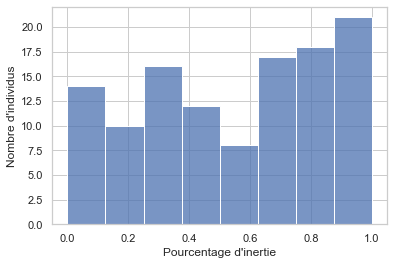

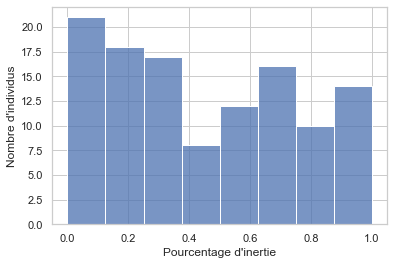

In [63]:
sns.histplot(x='COS2_1',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()
sns.histplot(x='COS2_2',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()

In [64]:
all_value[all_value['F1'] > 4]

,Rank,Team,Years,PTS,Win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
2,1,Chelsea,2016,93,0.789,85,33,61.80,28.62,686,209.1,141.438,1.032109,1.048286,Européen,CL,4.291422,1.079230
4,3,Chelsea,2018,72,0.553,63,39,63.97,38.11,1170,401.0,205.250,1.054968,1.032227,Européen,CL,4.574635,-1.591443
10,1,Manchester City,2017,100,0.842,106,27,91.43,24.51,1010,317.1,201.062,1.060621,1.053739,Européen,CL,6.670991,0.585420
11,1,Manchester City,2018,98,0.842,95,23,93.72,25.73,1200,410.4,222.500,1.023545,1.039917,Européen,CL,6.739791,0.740442
12,2,Manchester City,2019,81,0.684,102,35,102.21,37.00,1050,347.8,194.625,1.040355,1.089793,Européen,CL,5.828534,-0.814275
13,1,Manchester City,2020,86,0.711,83,32,77.72,30.61,1040,315.0,239.250,1.037689,1.045654,Européen,CL,5.445350,-0.166961
24,2,Manchester United,2017,81,0.658,68,28,59.04,43.54,849,272.8,142.875,1.070052,1.046344,Européen,CL,4.370594,-0.196795
39,2,Liverpool,2018,97,0.789,89,22,79.46,29.15,1170,394.1,239.438,1.020860,1.016410,Européen,CL,6.297987,0.938966
40,1,Liverpool,2019,99,0.842,85,33,75.19,39.57,1000,312.0,236.500,1.017088,1.046014,Européen,CL,5.729470,0.665353


In [65]:
all_value[all_value['F2'] < -1]

,Rank,Team,Years,PTS,Win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
1,10,Chelsea,2015,50,0.316,59,53,54.48,44.63,553,191.0,91.875,1.036477,1.043347,Non-Européen,NE,0.762526,-1.574632
4,3,Chelsea,2018,72,0.553,63,39,63.97,38.11,1170,401.0,205.250,1.054968,1.032227,Européen,CL,4.574635,-1.591443
19,8,Arsenal,2019,56,0.368,56,48,50.82,57.25,607,185.5,110.312,1.026434,1.054159,Non-Européen,NE,1.206859,-1.258675
25,6,Manchester United,2018,66,0.500,65,54,68.62,52.30,797,228.7,149.312,1.060910,1.054917,Européen,EL,2.749643,-1.791915
26,3,Manchester United,2019,66,0.474,66,36,66.19,38.06,670,163.5,154.562,1.059964,1.094856,Européen,CL,3.093593,-1.292106
27,2,Manchester United,2020,74,0.553,73,44,63.17,41.92,770,215.4,158.500,1.075211,1.071384,Européen,CL,3.703031,-1.372322
33,6,Tottenham,2019,59,0.421,61,47,49.02,54.13,806,247.0,139.375,1.039692,1.040737,Européen,EL,2.217354,-1.434582
34,7,Tottenham,2020,62,0.474,68,45,56.68,52.55,703,268.5,118.312,1.024182,1.078496,Non-Européen,NE,2.542085,-1.293387
41,3,Liverpool,2020,69,0.526,68,42,72.21,47.30,969,314.4,211.625,1.035918,1.042715,Européen,CL,3.811470,-1.268360
45,17,Southampton,2017,36,0.184,37,56,41.88,46.56,260,90.0,47.875,1.015749,1.041023,Non-Européen,NE,-1.614430,-1.511447


C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


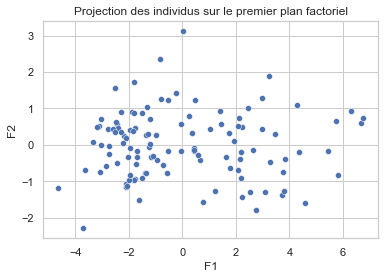

In [66]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['F2'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection des individus sur le premier plan factoriel')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

### Corrélation entre F1 et le classement du club correspondant ? 

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


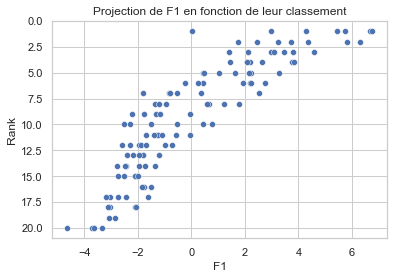

Covariance empirique :  -12.483879361934465
Coefficient de Pearson :  -0.8794338574167804

Les valeurs suivent une distribution linéaire


In [67]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
plt.ylim(21,0)
plt.show()
corré_quant(all_value['F1'],all_value['Rank'])

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


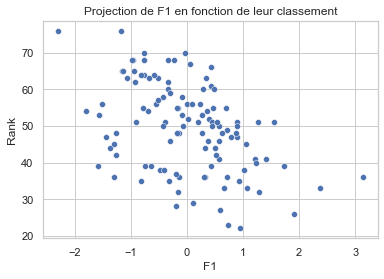

Covariance empirique :  -1.403045491903762
Coefficient de Pearson :  -0.2866265349652687

Les valeurs suivent une distribution linéaire


In [68]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
#plt.ylim(21,0)
plt.show()
corré_quant(all_value['F2'],all_value['Rank'])

In [69]:
all_value = all_value[(all_value['GA'] > 40)|(all_value['F2'] < 1)]

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Covariance empirique :  -12.485104551062399
Coefficient de Pearson :  -0.8929133254966225

Les valeurs suivent une distribution linéaire
Covariance empirique :  -3.042690540716804
Coefficient de Pearson :  -0.34138364097774365

Les valeurs suivent une distribution linéaire


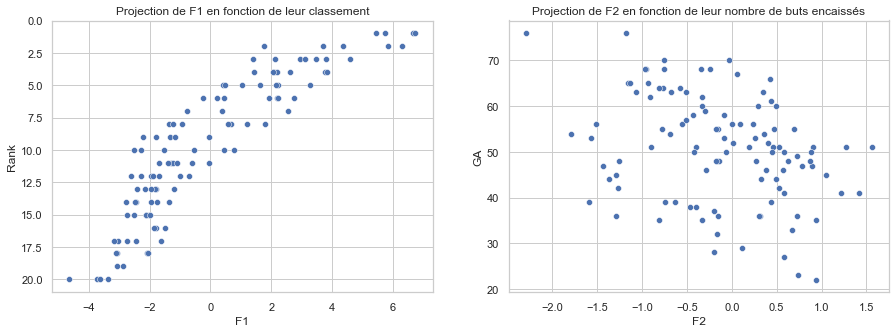

In [70]:
sns.set(style="whitegrid")
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')

plt.ylim(21,0)
corré_quant(all_value['F1'],all_value['Rank'])
corré_quant(all_value['F2'],all_value['GA'])
plt.subplot(122)
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F2 en fonction de leur nombre de buts encaissés')
plt.xlabel('F2')
plt.ylabel('GA')
#plt.ylim(21,0)
plt.show()

In [71]:
all_value[all_value['is_euro'] == 'Européen']

,Rank,Team,Years,PTS,Win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
3,5,Chelsea,2017,70,0.553,62,38,59.16,34.03,884,266.1,193.812,1.043219,1.007999,Européen,EL,3.282176,-0.470508
4,3,Chelsea,2018,72,0.553,63,39,63.97,38.11,1170,401.0,205.250,1.054968,1.032227,Européen,CL,4.574635,-1.591443
5,4,Chelsea,2019,66,0.526,69,54,76.23,41.09,705,173.0,156.250,1.045670,1.008031,Européen,CL,2.085526,-0.693481
6,4,Chelsea,2020,67,0.500,58,36,68.66,30.90,889,198.9,191.688,1.031581,0.999669,Européen,CL,2.623050,-0.148658
8,4,Manchester City,2015,66,0.500,71,41,66.20,37.47,499,129.3,109.312,1.021247,1.007897,Européen,CL,1.433388,0.577294
9,3,Manchester City,2016,78,0.605,80,39,79.85,29.61,606,210.4,109.750,1.050021,1.014982,Européen,CL,2.956745,0.435069
10,1,Manchester City,2017,100,0.842,106,27,91.43,24.51,1010,317.1,201.062,1.060621,1.053739,Européen,CL,6.670991,0.585420
11,1,Manchester City,2018,98,0.842,95,23,93.72,25.73,1200,410.4,222.500,1.023545,1.039917,Européen,CL,6.739791,0.740442
12,2,Manchester City,2019,81,0.684,102,35,102.21,37.00,1050,347.8,194.625,1.040355,1.089793,Européen,CL,5.828534,-0.814275
13,1,Manchester City,2020,86,0.711,83,32,77.72,30.61,1040,315.0,239.250,1.037689,1.045654,Européen,CL,5.445350,-0.166961


Covariance empirique :  704.7086412677392
Coefficient de Pearson :  0.9437131498422201

Les valeurs suivent une distribution linéaire


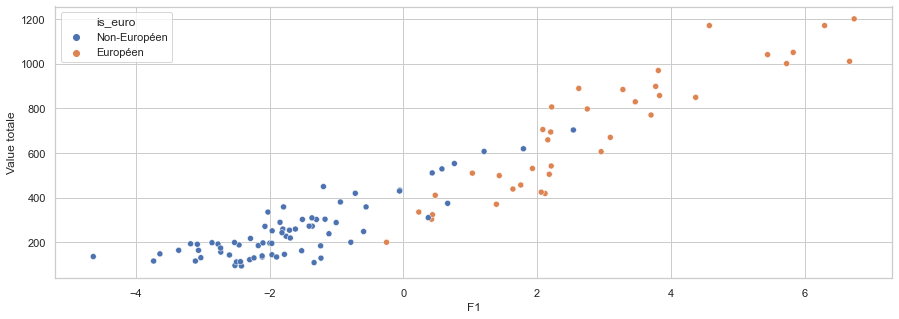

Covariance empirique :  0.6178242939256384
Coefficient de Pearson :  0.01905787762131972

Les valeurs suivent une distribution linéaire


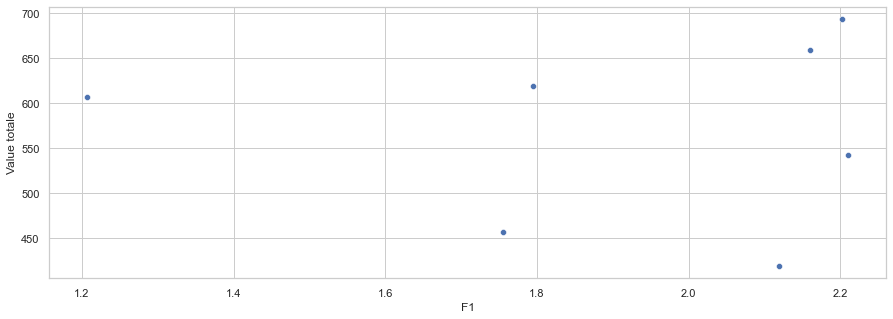

In [72]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['F1'],all_value['Value totale'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',data=all_value[all_value['Team'] == 'Arsenal'])
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value[all_value['Team'] == 'Arsenal']['F1'],all_value[all_value['Team'] == 'Arsenal']['Value totale'])
plt.show()

In [73]:
all_value.head()

,Rank,Team,Years,PTS,Win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
1,10,Chelsea,2015,50,0.316,59,53,54.48,44.63,553,191.0,91.875,1.036477,1.043347,Non-Européen,NE,0.762526,-1.574632
3,5,Chelsea,2017,70,0.553,62,38,59.16,34.03,884,266.1,193.812,1.043219,1.007999,Européen,EL,3.282176,-0.470508
4,3,Chelsea,2018,72,0.553,63,39,63.97,38.11,1170,401.0,205.250,1.054968,1.032227,Européen,CL,4.574635,-1.591443
5,4,Chelsea,2019,66,0.526,69,54,76.23,41.09,705,173.0,156.250,1.045670,1.008031,Européen,CL,2.085526,-0.693481
6,4,Chelsea,2020,67,0.500,58,36,68.66,30.90,889,198.9,191.688,1.031581,0.999669,Européen,CL,2.623050,-0.148658


In [74]:
var_F2 = []
for i,a in zip(all_value['Value défense'],all_value['coef défense']):
    var_F2.append((a ** 3))
    print(i,'|',a,'|',(a ** 3))

91.875 | 1.036476842105263 | 1.1134707409731013
193.812 | 1.0432194444444445 | 1.1353428249486
205.25 | 1.0549676470588234 | 1.1741333494157529
156.25 | 1.04567 | 1.1433625028522634
191.688 | 1.0315806666666665 | 1.0977655121362797
109.312 | 1.021246875 | 1.0651045055621462
109.75 | 1.050020666666667 | 1.1576933563454097
201.062 | 1.0606207142857145 | 1.1931095291636329
222.5 | 1.023545 | 1.0723111536466035
194.625 | 1.040355 | 1.1260162972427386
239.25 | 1.0376887500000005 | 1.1173811103084643
79.688 | 1.0703536363636366 | 1.2262580363007631
89.312 | 0.9958331578947368 | 0.9875514890565003
112.188 | 1.01244375 | 1.0377977176184747
107.688 | 1.030300588235294 | 1.093683961395287
116.812 | 1.0218087500000002 | 1.0668634874417458
110.312 | 1.026434 | 1.0814167399935146
120.875 | 1.036212777777778 | 1.1126199173357492
87.0 | 1.0307023529411763 | 1.094963903348283
97.312 | 1.04482875 | 1.140605189090001
117.562 | 1.0363857894736843 | 1.1131773175288349
142.875 | 1.0700519999999998 | 1.2252

Covariance empirique :  704.7086412677392
Coefficient de Pearson :  0.9437131498422201

Les valeurs suivent une distribution linéaire


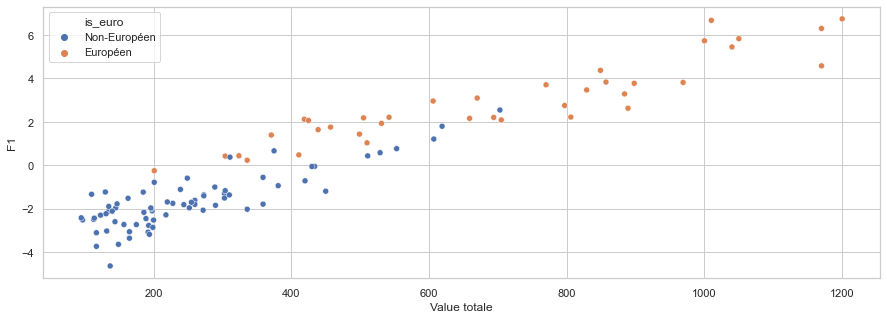

Covariance empirique :  -0.5083689551756546
Coefficient de Pearson :  -0.5752585859753874

Les valeurs suivent une distribution linéaire


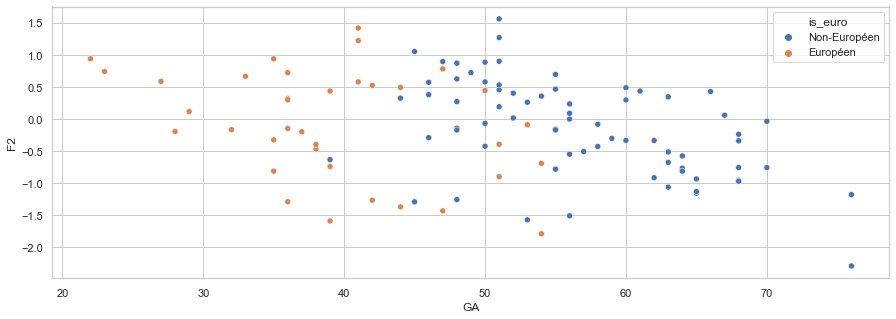

In [75]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='Value totale',y='F1',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='GA',y='F2',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(var_F2,all_value['xGA'])
plt.show()

In [76]:
# Déterminer la fonction de la trend
x = all_value['Value totale']
y_F1= all_value['F1']
y_F2= all_value['F2']
z_F1 = np.polyfit(x,y_F1,1)
z_F2 = np.polyfit(x,y_F2,1)
print ("{0}x + {1}".format(*z_F1))
print ("{0}x + {1}".format(*z_F2))
y_list_F1 = []
y_list_F2 = []
for i in x:
    y_list_F1.append(0.00864271832605479*i + -3.594282721496704)
    y_list_F2.append(-0.0005877676701007274*i + 0.11092845000995885)

0.00864271832605479x + -3.594282721496704
-0.0005877676701007274x + 0.11092845000995885


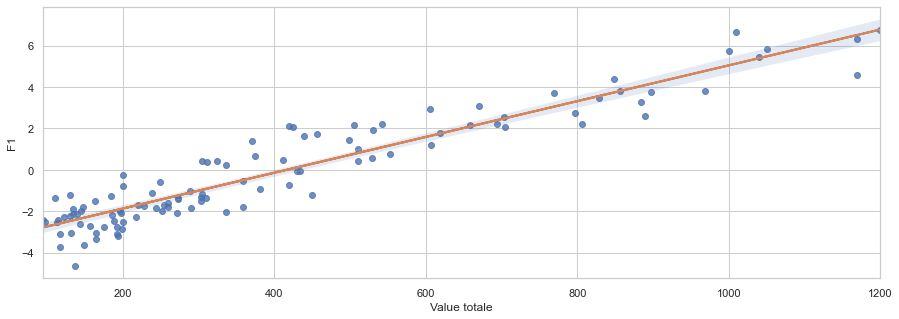

In [77]:
plt.figure(figsize=[15,5])
sns.regplot(x='Value totale',y='F1',data=all_value)
plt.plot(all_value['Value totale'],y_list_F1)
# corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()

La fonction que nous avons obtenue est correcte puisque la trend du regplot et la fonction se superposent

In [78]:
all_value['trend'] = y_list_F1

In [79]:
all_value[all_value['Team'] == 'Arsenal']

,Rank,Team,Years,PTS,Win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2,trend
14,3,Arsenal,2014,75,0.579,71,36,69.80,35.72,419,124.7,79.688,1.070354,1.005224,Européen,CL,2.118636,0.723050,0.027016
15,2,Arsenal,2015,71,0.526,65,36,73.53,33.86,457,127.9,89.312,0.995833,1.086779,Européen,CL,1.755111,0.318103,0.355440
16,5,Arsenal,2016,75,0.605,77,44,63.58,47.07,542,144.1,112.188,1.012444,1.043749,Européen,EL,2.210175,0.492476,1.090071
17,6,Arsenal,2017,63,0.500,74,51,72.27,48.75,694,245.9,107.688,1.030301,1.040569,Européen,EL,2.202336,-0.901307,2.403764
18,5,Arsenal,2018,70,0.553,73,51,64.80,57.30,659,188.7,116.812,1.021809,1.042007,Européen,EL,2.159486,-0.395452,2.101269
19,8,Arsenal,2019,56,0.368,56,48,50.82,57.25,607,185.5,110.312,1.026434,1.054159,Non-Européen,NE,1.206859,-1.258675,1.651847
20,8,Arsenal,2020,61,0.474,55,39,52.25,43.23,619,143.8,120.875,1.036213,1.056024,Non-Européen,NE,1.795130,-0.634752,1.755560


In [80]:
# plt.figure(figsize=[20,5])
# plt.subplot(121)
# list_trend = list(abs(all_value[all_value['Team'] == 'Arsenal']['trend']*10))
# list_value = list(abs(all_value[all_value['Team'] == 'Arsenal']['Value totale']/10))
# sns.lineplot(x='Years',y='Rank',data=all_value[all_value['Team'] == 'Arsenal'],label='Rank')
# sns.lineplot(x='Years',y=list_trend,data=all_value[all_value['Team'] == 'Arsenal'],label='trend')
# # sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
# plt.ylim(21,0)
# plt.subplot(122)

# sns.lineplot(x='Years',y='Value totale',data=all_value[all_value['Team'] == 'Arsenal'],label='Valeur totale')
# plt.show()

A partir des corrélations, on va va prévoir se baser sur 3 variables pour prévoir le futur classement du mhsc :
* Classement
* F1
* Valeur de l'effectif

In [81]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'Win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail', 'F1', 'F2', 'trend'],
      dtype='object')

In [85]:
variables = all_value[['Team','Rank','F1','Value totale','Years','is_euro','is_euro_detail','trend','Win_rate']]

In [86]:
list_value = []
for i in variables['Value totale']:
    if i < 150:
        list_value.append('> 150 m')
    elif (i >= 150)&(i < 300): 
        list_value.append('150 m < i < 300 m')
    elif (i >= 300)&(i < 500): 
        list_value.append('300 m < i < 500 m')
    elif (i >= 500)&(i < 750): 
        list_value.append('500 m < i < 750 m')
    elif (i >= 750)&(i < 1000): 
        list_value.append('750 m < i < 1000 m')
    elif i >= 1000: 
        list_value.append('> 1000 m')
variables['ech_value'] = list_value

<ipython-input-86-b6ffc7f01049>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['ech_value'] = list_value


In [87]:
pal = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

In [88]:
# euro_var

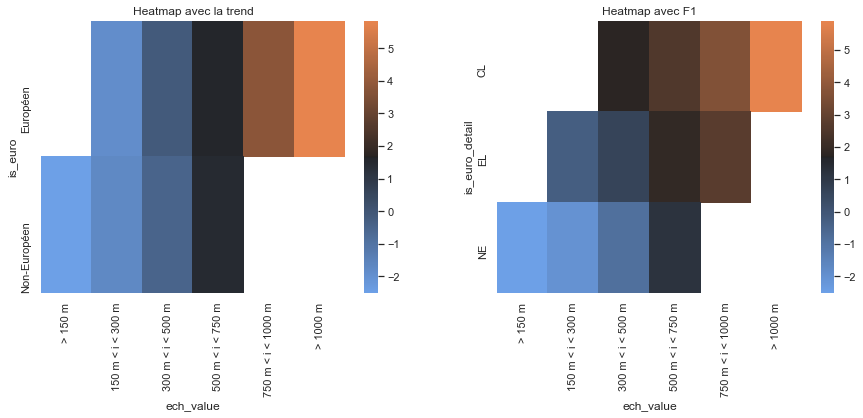

In [89]:
euro_var = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','trend']].pivot(index='is_euro',columns='ech_value',values='trend')[['> 150 m','150 m < i < 300 m','300 m < i < 500 m','500 m < i < 750 m','750 m < i < 1000 m','> 1000 m']]
euro_detail_var = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','trend']].pivot(index='is_euro_detail',columns='ech_value',values='trend')[['> 150 m','150 m < i < 300 m','300 m < i < 500 m','500 m < i < 750 m','750 m < i < 1000 m','> 1000 m']]
euro_var_F1 = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','F1']].pivot(index='is_euro',columns='ech_value',values='F1')[['> 150 m','150 m < i < 300 m','300 m < i < 500 m','500 m < i < 750 m','750 m < i < 1000 m','> 1000 m']]
euro_detail_var_F1 = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','F1']].pivot(index='is_euro_detail',columns='ech_value',values='F1')[['> 150 m','150 m < i < 300 m','300 m < i < 500 m','500 m < i < 750 m','750 m < i < 1000 m','> 1000 m']]
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.heatmap(euro_var,cmap=pal)
plt.title('Heatmap avec la trend')
plt.subplot(122)
sns.heatmap(euro_detail_var_F1,cmap=pal)
plt.title('Heatmap avec F1')
plt.show()
# plt.figure(figsize=[15,5])
# plt.subplot(121)
# sns.heatmap(euro_detail_var,cmap=pal)
# plt.title('Heatmap avec la trend')
# plt.subplot(122)
# sns.heatmap(euro_detail_var_F1,cmap=pal)
# plt.title('Heatmap avec F1')
# plt.show()

### Prédictions 

Régression logistique

K-Means

In [90]:
# <!-- * analyse de la variance -->

In [91]:
variables.head()

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,Win_rate,ech_value
1,Chelsea,10,0.762526,553,2015,Non-Européen,NE,1.185141,0.316,500 m < i < 750 m
3,Chelsea,5,3.282176,884,2017,Européen,EL,4.045880,0.553,750 m < i < 1000 m
4,Chelsea,3,4.574635,1170,2018,Européen,CL,6.517698,0.553,> 1000 m
5,Chelsea,4,2.085526,705,2019,Européen,CL,2.498834,0.526,500 m < i < 750 m
6,Chelsea,4,2.623050,889,2020,Européen,CL,4.089094,0.500,750 m < i < 1000 m


#### K-Means 

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


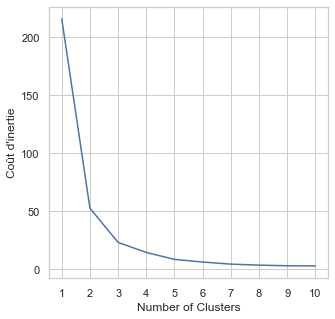

In [92]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition,preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

data = variables[["trend","Value totale"]]
X = data.values
X_scaled = preprocessing.StandardScaler().fit_transform(X)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    
fig_1 = plt.figure(figsize=(5,5))

#plt.style.use("fivethirtyeight")
sns.set(style="whitegrid")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Coût d'inertie")
plt.savefig('graph_cout_inert.png')
plt.show()

In [93]:
# Projection des individus
# Réduire  ici est nécessaire car les variables sont pas exprimées dans la même unité
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#X_projected = pca.transform(X_scaled)

# Clustering par K-means
# 2 clusters
km = KMeans(n_clusters=2)
km.fit(X_scaled)
y_means = km.predict(X_scaled)

km3 = KMeans(n_clusters=3)
km3.fit(X_scaled)
y_means3 = km3.predict(X_scaled)

clust_lab3 = km3.labels_

ValueError: 'c' argument has 108 elements, which is inconsistent with 'x' and 'y' with size 116.

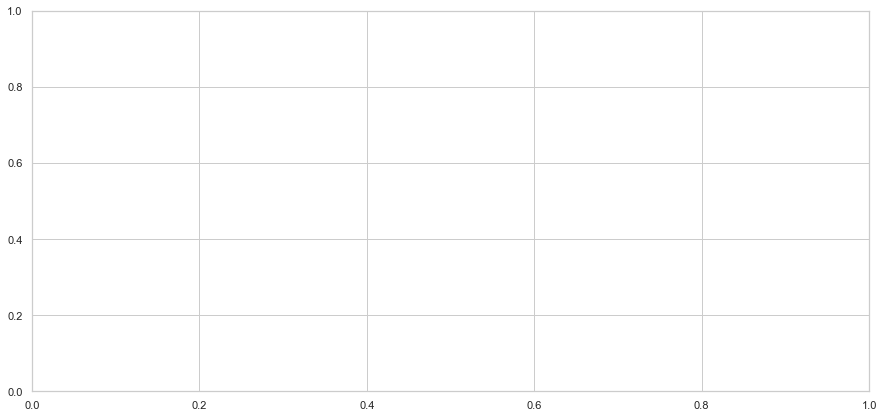

In [94]:
import matplotlib.patches as mpatches
# Visualisation de nos deux clusters dans le premier plan factoriel

plt.figure(figsize=(15, 7))

categories = km.labels_
colormap = np.array(['royalblue','coral'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='1')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

plt.figure(figsize=(15, 7))
categories3 = km3.labels_
colormap = np.array(['royalblue','coral','grey'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories3], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='2')
plt.legend(handles=[lab_0, lab_1, lab_2])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 3 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

In [95]:
variables['clusters'] = categories
# variables['clusters_3'] = categories3

<ipython-input-95-10f62482c47d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['clusters'] = categories


In [96]:
variables

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,Win_rate,ech_value,clusters
1,Chelsea,10,0.762526,553,2015,Non-Européen,NE,1.185141,0.316,500 m < i < 750 m,1
3,Chelsea,5,3.282176,884,2017,Européen,EL,4.045880,0.553,750 m < i < 1000 m,0
4,Chelsea,3,4.574635,1170,2018,Européen,CL,6.517698,0.553,> 1000 m,0
5,Chelsea,4,2.085526,705,2019,Européen,CL,2.498834,0.526,500 m < i < 750 m,0
6,Chelsea,4,2.623050,889,2020,Européen,CL,4.089094,0.500,750 m < i < 1000 m,0
...,...,...,...,...,...,...,...,...,...,...,...
110,Brighton,15,-2.525024,200,2019,Non-Européen,NE,-1.865739,0.237,150 m < i < 300 m,1
111,Brighton,16,-1.844132,290,2020,Non-Européen,NE,-1.087894,0.237,150 m < i < 300 m,1
112,Huddersfield,20,-4.636708,137,2018,Non-Européen,NE,-2.410230,0.079,> 150 m,1
114,Wolverhampton Wanderers,13,-1.195150,450,2020,Non-Européen,NE,0.294941,0.316,300 m < i < 500 m,1


<AxesSubplot:xlabel='clusters', ylabel='is_euro'>

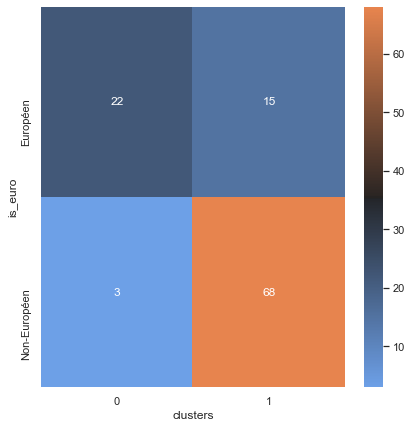

In [97]:
euro = pd.crosstab(variables['is_euro'], variables["clusters"],margins=True,margins_name='Total')
# euro_bis = pd.crosstab(variables['is_euro_detail'], variables["clusters_3"],margins=True,margins_name='Total')
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.heatmap(euro.iloc[0:2,0:-1],annot=True, cmap=pal)
# plt.subplot(122)
# sns.heatmap(euro_bis.iloc[0:3,0:-1],annot=True, cmap=pal)
# plt.show()

Résultat beaucoup trop approximatif pour le second K-Means

Cependant, on peut poursuivre l'analyse avec le premier K-Means dont les résultats sont pas si mauvais, seulement 5 faux-négatifs et faux-positifs

In [98]:
from sklearn.model_selection import train_test_split
variables_corr = variables[['Team','Rank','trend','Value totale','Years','is_euro','ech_value','clusters','Win_rate']]
list_euro = []
for i in variables_corr['is_euro']:
    if i == 'Européen':
        list_euro.append(1)
    elif i == 'Non-Européen':
        list_euro.append(0)
variables_corr['is_euro'] = list_euro 
xtrain, xtest, ytrain, ytest = train_test_split(variables_corr[['trend']], variables_corr[['is_euro']], train_size=0.8)

<ipython-input-98-450888eb56c9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_corr['is_euro'] = list_euro


In [99]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import pickle

modele_logit = LogisticRegression()
modele_logit.fit(xtrain,ytrain)
precision = modele_logit.score(xtest,ytest)

with open('model_mhsc.pkl', 'wb') as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(modele_logit)

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


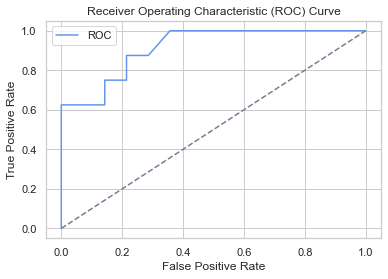

In [100]:
probs = modele_logit.predict_proba(xtest)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(ytest, probs) 
plot_roc_curve(fper, tper)

#### Matrice de confusion

In [101]:
variables_corr = variables_corr.reset_index()
ytest = ytest.reset_index()

In [102]:
variables_corr

,index,Team,Rank,trend,Value totale,Years,is_euro,ech_value,clusters,Win_rate
0,1,Chelsea,10,1.185141,553,2015,0,500 m < i < 750 m,1,0.316
1,3,Chelsea,5,4.045880,884,2017,1,750 m < i < 1000 m,0,0.553
2,4,Chelsea,3,6.517698,1170,2018,1,> 1000 m,0,0.553
3,5,Chelsea,4,2.498834,705,2019,1,500 m < i < 750 m,0,0.526
4,6,Chelsea,4,4.089094,889,2020,1,750 m < i < 1000 m,0,0.500
...,...,...,...,...,...,...,...,...,...,...
103,110,Brighton,15,-1.865739,200,2019,0,150 m < i < 300 m,1,0.237
104,111,Brighton,16,-1.087894,290,2020,0,150 m < i < 300 m,1,0.237
105,112,Huddersfield,20,-2.410230,137,2018,0,> 150 m,1,0.079
106,114,Wolverhampton Wanderers,13,0.294941,450,2020,0,300 m < i < 500 m,1,0.316


In [103]:
data_predict = pd.merge(variables_corr,ytest,how = 'inner',on='index')
data_predict = data_predict.drop(['index'],axis=1)

In [104]:
data_predict

,Team,Rank,trend,Value totale,Years,is_euro_x,ech_value,clusters,Win_rate,is_euro_y
0,Chelsea,4,4.089094,889,2020,1,750 m < i < 1000 m,0,0.500,1
1,Manchester City,3,1.643205,606,2016,1,500 m < i < 750 m,0,0.605,1
2,Manchester City,1,5.134863,1010,2017,1,> 1000 m,0,0.842,1
3,Manchester United,6,0.995001,531,2016,1,500 m < i < 750 m,1,0.474,1
4,Tottenham,5,-0.966896,304,2014,1,300 m < i < 500 m,1,0.500,1
5,Tottenham,3,-0.387834,371,2015,1,300 m < i < 500 m,1,0.500,1
6,Tottenham,6,3.371748,806,2019,1,750 m < i < 1000 m,0,0.421,1
7,Liverpool,6,-0.794042,324,2014,1,300 m < i < 500 m,1,0.474,1
8,Southampton,15,-0.690329,336,2020,0,300 m < i < 500 m,1,0.316,0
9,Swansea,15,-2.237376,157,2016,0,150 m < i < 300 m,1,0.316,0


In [105]:
predict = pd.crosstab(data_predict['is_euro_x'], data_predict["is_euro_y"],rownames=['Actual'], colnames=['Predicted'],margins=True,margins_name='Total')

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

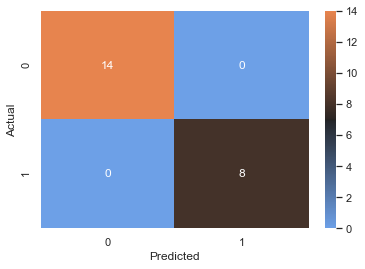

In [106]:
sns.heatmap(predict.iloc[0:2,0:-1],annot=True, cmap=pal)

In [107]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(' ')
print('Precision: %.3f' % precision_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Recall: %.3f' % recall_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Accuracy: %.3f' % accuracy_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('F1 Score: %.3f' % f1_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))

 
Precision: 1.000
Recall: 1.000
Accuracy: 1.000
F1 Score: 1.000


In [108]:
print(sklearn.metrics.classification_report(data_predict['is_euro_x'], data_predict["is_euro_y"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         8

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [63]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import Logit
mode = Logit(endog=ytrain,exog=xtrain)
lr = mode.fit()

lr.summary()

Optimization terminated successfully.
         Current function value: 0.350507
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_euro   No. Observations:                   86
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                            0
Date:                Tue, 17 Aug 2021   Pseudo R-squ.:                  0.4185
Time:                        18:06:42   Log-Likelihood:                -30.144
converged:                       True   LL-Null:                       -51.839
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          1.1959      0.234      5.113      0.000       0.737       1.654
==============================================================================
"""